# Phonon dispersion relations
This notebook will contain the code for generating phonon dispersion relations.

## Imports

In [1]:
import numpy as np
import re
import subprocess
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib as mpl
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=300 # dots per inch
import scipy as sp
import itertools

## Housekeeping functions

### Extract thermal conductivity

In [2]:
def extract_TC(file_path):
    """Extracts the thermal conductivity (TC) value from the logfile,
    assuming that the LAMMPS script has already been run.
    Also takes their thermal conductivities
    
    Inputs:
    file_path - path to the logfile we want to read
    
    Outputs:
    thermal_conductivity - thermal conductivity extracted from the logfile (if it is there)
    k_x - thermal conductivity along the x direction extracted from logfile
    k_y - thermal conductivity along the y direction extracted from logfile
    k_z - thermal conductivity along the z direction extracted from logfile
    """
    
    # Open file in Python to read all lines
    with open(file_path, 'r') as file:
        content = file.read()

    # Looks for lines of the form {average conductivity: X[W/mk] @ 70 K, Y /A\^3}
    k_pattern = re.compile(r'average conductivity:\s*([\d.]+)\s*\[W/mK\]', re.IGNORECASE)
    # Search logfile for that line
    k_lines = k_pattern.findall(content)
    
    # If the line exists, extract thermal conductivity. Inform user if otherwise
    if len(k_lines)>0:
        thermal_conductivity = float(k_lines[0])
    else:
        return 'Thermal conductivity not found for this file'
    
    # Look for lines of the form {diretional thermal conductivites: k_x = kx, k_y = ky, k_z = kz}
    ki_pattern = re.compile(
        r'Directional thermal conductivities:\s*'
        r'k_x\s*=\s*(?P<kx>[+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)\s*,\s*'
        r'k_y\s*=\s*(?P<ky>[+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)\s*,\s*'
        r'k_z\s*=\s*(?P<kz>[+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)',
        re.IGNORECASE)
    
    # If the line exists, extract directional conductivity. Inform user if otherwise
    ki_lines = ki_pattern.findall(content)
    if ki_lines:
        kx_str, ky_str, kz_str = ki_lines[0]
        kx = float(kx_str)
        ky = float(ky_str)
        kz = float(kz_str)
    else:
        return 'Directional thermal conductivites not found for this file'
    
    return thermal_conductivity, kx, ky, kz

### Update seeds

In [3]:
def update_seed(file_path, new_seed):
    """Updates the seed for the velocity initialisation command in the LAMMPS input script.
    The velocity in LAMMPS is randomly initialised using a given seed.
    
    Inputs:
    file_path - path to the LAMMPS script which will be updated
    new_seed - new seed to be used in velocity initialisation
    
    Outputs:
    Updated file, if amendments have been made"""
    
    # Looks for lines of the form {variable r equal X}
    pattern = re.compile(r'^\s*variable\s+r\s*equal\s*[\d.]+\s*$')
    
    # Open the file in read mode to read all lines
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Open the file in write mode to update the lines iteratively
    with open(file_path, 'w') as file:
        for line in lines:
            # If the pattern exists, update the line with the new seed in place
            if pattern.match(line):
                line = f"variable r equal {new_seed}\n"
            
            # Write the line to the file
            file.write(line)

### Update masses

In [4]:
def update_masses(file_path, new_mass1, new_mass2):
    """Updates the mass1 and mass2 variables in the LAMMPS input script.
    This assumes of course that the LAMMPS script concerns two fundamental atoms.
    
    Inputs:
    file_path - path to the LAMMPS script which will be updated
    new_mass1 - new mass 1 (g/mol)
    new_mass2 - new mass 2 (g/mol)
    
    Outputs:
    Updated file, if any amendments have been made"""
    
    # Looks for lines of the form {mass    1 X} and {mass    2 Y}
    target_pattern_mass1 = re.compile(r'^\s*mass\s+1\s+[\d.]+\s*$')
    target_pattern_mass2 = re.compile(r'^\s*mass\s+2\s+[\d.]+\s*$')
    
    # Open the file in read mode to read all lines
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Open the file in write mode to update the lines iteratively
    with open(file_path, 'w') as file:
        for line in lines:
            # --- Mass 1 ---
            # If the pattern exists, replace mass 1 with new_mass1
            if target_pattern_mass1.match(line):
                line = f"mass 1 {new_mass1}\n"
            # --- Mass 2 ---
            if target_pattern_mass2.match(line):
                line = f"mass 2 {new_mass2}\n"
                
            file.write(line)

### Update dimensionality (I never use this?)

In [5]:
def update_dimensionality(file_path, new_dimension):
    """Updates the dimensionality written in the LAMMPS input script.
    
    Inputs:
    file_path - path to the LAMMPS script which will be updated
    
    Outputs:
    Updated file, if any amendments have been made"""
    
    # Look for lines of the form {dimension X}
    pattern = re.compile(r'^\s*dimension\s+(\d+)\b(?=\s*(?:#|$))')
    
    # Open the file in read mode to read all lines
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Open the file in write mode to update the lines iteratively
    with open(file_path, 'w') as file:
        # Update any line which matches line pattern
        for line in lines:
            if pattern.match(line):
                line = f"dimension {new_dimension}\n"
            
            file.write(line)

### Bash function

In [6]:
def run_bash():
    """ I want to describe this better """
    !bash {'lammps.sh'}
    return

### Create LAMMPS compatible datafile

In [7]:
def layered_datafile_creation(Ncells, Nlayers, spacings):
    """Creates a datafile of an arbitrary crystallographic material which is LAMMPS compatible.
    Uses the generate_FCC function to generate FCC lattice.
    See the markdown above where this function is defined for details on the datafile structure.
    Alternativiely, view the eim example in LAMMPS.
    
    Inputs:
    
    Output:
    datafile.txt - datafile in LAMMPS format defining the structure"""

    # Find positions, types, IDs and group into data
    positions, atom_types = generate_FCC(Ncells, Nlayers, spacings)
    num_atoms = len(atom_types)
    IDs = np.array(range(1, num_atoms+1))
    data = np.column_stack((IDs, atom_types, positions))

    # Will take the form [ID] [Type] [X1] [Y1] [Z1] column-repeated many times
    np.savetxt('datafile.txt', data, fmt = '%i %i %s %s %s',header = 
f'''# Title

{len(data)} atoms

{len(np.unique(data[:,1]))} atom types

{min(positions[:,0])} {max(positions[:,0]) + 0.5*spacings[0]} xlo xhi
{min(positions[:,1])} {max(positions[:,1]) + 0.5*spacings[1]} ylo yhi
{min(positions[:,2])} {max(positions[:,2]) + 0.5*spacings[2]} zlo zhi

Atoms
''', comments = '')
    
    return

### Generate FCC structure

In [8]:
def generate_FCC(Ncells, Nlayers, spacings):
    """Creates a face-centered cubic (FCC) structure.
    This specific function assumes one type of atom only.
    
    Inputs:
    Ncells - number of cells as a two-dimensional NumPy vector [Nx, Nz]
    Nlayers - number of layers along y (integer)
    spacings - lattice constant / spacing between cells
    
    Outputs:
    positions - two-dimensional NumPy array of positions [x,y,z] per atom
    type_atoms - one-dimensional NumPy array labelling atom types as integers"""
    # Create storage arrays
    positions = []
    atom_types = []

    # Extract spacing and cells
    x_spacing, y_spacing, z_spacing = spacings
    Ncells_x, Ncells_z = Ncells

    # Determine Cartesian range of atoms
    x_range, z_range = range(2*Ncells_x), range(2*Ncells_z) 
    y_range = range(0, 2*Nlayers)

    # Loop over the range of x,y,z
    for x,y,z in itertools.product(x_range, y_range, z_range):
        # First layer: y=0
        if (x%2 == 0 and y%2 == 0 and z%2 == 0):
            x, z = x*0.5*x_spacing, z*0.5*z_spacing
            y = (y//2)*y_spacing
            # Append positions and types
            positions.append([x,y,z])
            atom_types.append(int(1))

        # Second layer: y=1
        elif (x%2 == 0 and y%2 == 1 and z%2 == 1):
            x, z = x*0.5*x_spacing, z*0.5*z_spacing
            y = (y//2 + 0.5)*y_spacing
            # Append positions and types
            positions.append([x,y,z])
            atom_types.append(int(1))

        # First layer again (sorry): y=0
        elif (x%2 == 1 and y%2 == 0 and z%2 == 1):
            x, z = x*0.5*x_spacing, z*0.5*z_spacing
            y = (y//2)*y_spacing
            # Append positions and types
            positions.append([x,y,z])
            atom_types.append(int(1))

        # Second layer: y=1
        elif (x%2 == 1 and y%2 == 1 and z%2 == 0):
            x, z = x*0.5*x_spacing, z*0.5*z_spacing
            y = (y//2 + 0.5)*y_spacing
            # Append positions and types
            positions.append([x,y,z])
            atom_types.append(int(1))
                                    
    # Convert lists to arrays for plotting & return
    positions = np.array(positions)
    atom_types = np.array(atom_types)
    
    return positions, atom_types

### Generating `map.in` file
This is new in our investigation and is needed if we want to map the phonon dispersion relation. Examples/PACKAGES/phonon helped me tremendously for this section.

The `map.in` file contains the mapping information between the lattice indices and the atom ID's, as mentioned in the LAMMPS documentation (https://docs.lammps.org/fix_phonon.html).

LAMMPS examples suggests that map.in takes the following form

        [Cells along x] [Cells along y] [Cells along z] [Amount of basis atoms per unit cell] 
        [Cell 0x] [Cell 0y] [Cell 0z] [Atom 0 of basis] [Atom 1]
        [Cell 0x] [Cell 0y] [Cell 0z] [Atom 1 of basis] [Atom 2]
        [Cell 0x] [Cell 0y] [Cell 0z] ...               ...
        [Cell 0x] [Cell 0y] [Cell 0z] [Atom N-1 of basis] [Atom N]
        [Cell 1x] [Cell 0y] [Cell 0z] [Atom 0 of basis] [Atom N+1]
                  ...       ...       ...               ...
        [Cell 2x] [Cell 0y] [Cell 0z] [Atom 0 of basis] [Atom ...]
        ...
        [Cell Nx] [Cell 0y] [Cell 0z] [Atom 0 of basis] [Atom ...]
        [Cell Nx] [Cell 1y] ...
        [Cell Nx] [Cell Ny] [Cell Nz] [Atom N-1 of basis] [Final atom ID]

so the way it works is that:
- Starts off with the first cell, defines atoms within that cell
- Goes to the next cell in x, defines atoms within that cell
- Repeats till all cells along x are filled
- Then fills all cells along y, then fills all cells along z

For a 5x5x5 arrangement of FCC conventional cells, `map.in` should be

        5 5 5 4
        #l1 l2 l3 k atom_id
        0 0 0 0 1
        0 0 0 1 2
        0 0 0 2 3
        0 0 0 3 4
        1 0 0 0 5
        1 0 0 1 6
        1 0 0 2 7
        1 0 0 3 8
        2 0 0 0 9
        ...


In [9]:
def generate_map_in(Ncells, Nlayers):
    """Creates a map.in structure for a face-centered cubic (k=4).
    
    Inputs:
    Ncells - number of cells as a two-dimensional NumPy vector [Nx, Nz]
    Nlayers - number of layers along y (integer)
    
    Outputs:
    map.in file - file which contains the construction of the structure in terms of cells"""
    # Create storage arrays
    positions = []; atom_types = []; k = []

    # Extract cells
    Ncells_x, Ncells_z = Ncells

    # Determine Cartesian range of atoms
    x_range, z_range = range(2*Ncells_x), range(2*Ncells_z) 
    y_range = range(0, 2*Nlayers)

    # Loop over the range of x,y,z
    for x,y,z in itertools.product(x_range, y_range, z_range):
        # Case k=0: (0,0,0)
        if (x%2 == 0 and y%2 == 0 and z%2 == 0):
            k.append(0)
            positions.append([x//2, y//2, z//2])
            atom_types.append(int(1))

        # Case k=1: (0, 1/2, 1/2)
        elif (x%2 == 0 and y%2 == 1 and z%2 == 1):
            k.append(1)
            positions.append([x//2, y//2, z//2])
            atom_types.append(int(1))

        # Case k=2: (1/2, 0, 1/2)
        elif (x%2 == 1 and y%2 == 0 and z%2 == 1):
            k.append(2)
            positions.append([x//2, y//2, z//2])
            atom_types.append(int(1))

        # Case k=3: (1/2, 1/2, 0)
        elif (x%2 == 1 and y%2 == 1 and z%2 == 0):
            k.append(3)
            positions.append([x//2, y//2, z//2])
            atom_types.append(int(1))
            
    # Convert lists to arrays for writing into map.in
    k = np.array(k, dtype=int)
    positions = np.array(positions, dtype=int)
    atom_types = np.array(atom_types, dtype=int)

    num_atoms = len(atom_types)
    IDs = np.array(range(1, num_atoms+1))
    data = np.column_stack((positions, k, IDs))

    np.savetxt('map.in', data, fmt = '%d %d %d %d %d',header = 
f'''{Ncells_x} {Nlayers} {Ncells_z} {4}
''', comments = '')
    
    return

In [10]:
# Set up arbitrary number of cells, layers spacings
Ncells = np.array([5,5])
Nlayers = 5
spacings = np.array([5.376, 5.376, 5.376])
# Update masses (not needed for what we're doing here)
update_masses("fixphonon.txt", 39.948, 39.948)

# Extract positions
positions, atom_types = generate_FCC(Ncells, Nlayers, spacings)

# Count amount of occurences of type 1 and 2
atom_types = np.asarray(atom_types)
unique, counts = np.unique(atom_types, return_counts=True)
dict(zip(unique, counts))

{np.int64(1): np.int64(500)}

:)

In [59]:
generate_map_in(Ncells, Nlayers)
layered_datafile_creation(Ncells, Nlayers, spacings)

After running `fix phonon ...` in my LAMMPS input script I get a file called `DisorderedPhonon.bin.XXXXXXX` 

Next the README files point us to using the auxillary analysing code "phana" to obtain the dispersion relation. However, the installation of phana is not particularly easy as it involves the 

Then I run `phana DisorderedPhonon.bin.500000` in the command prompt

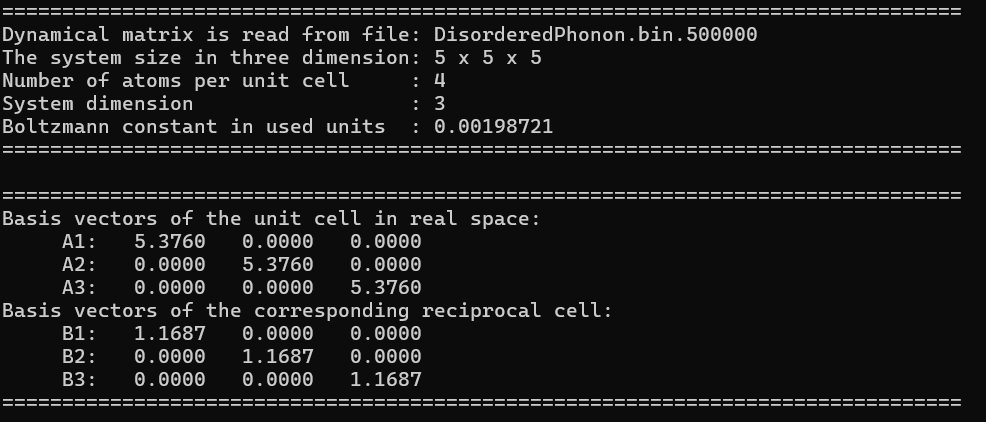

## Monoatomic dispersion relation, X -> gamma -> X

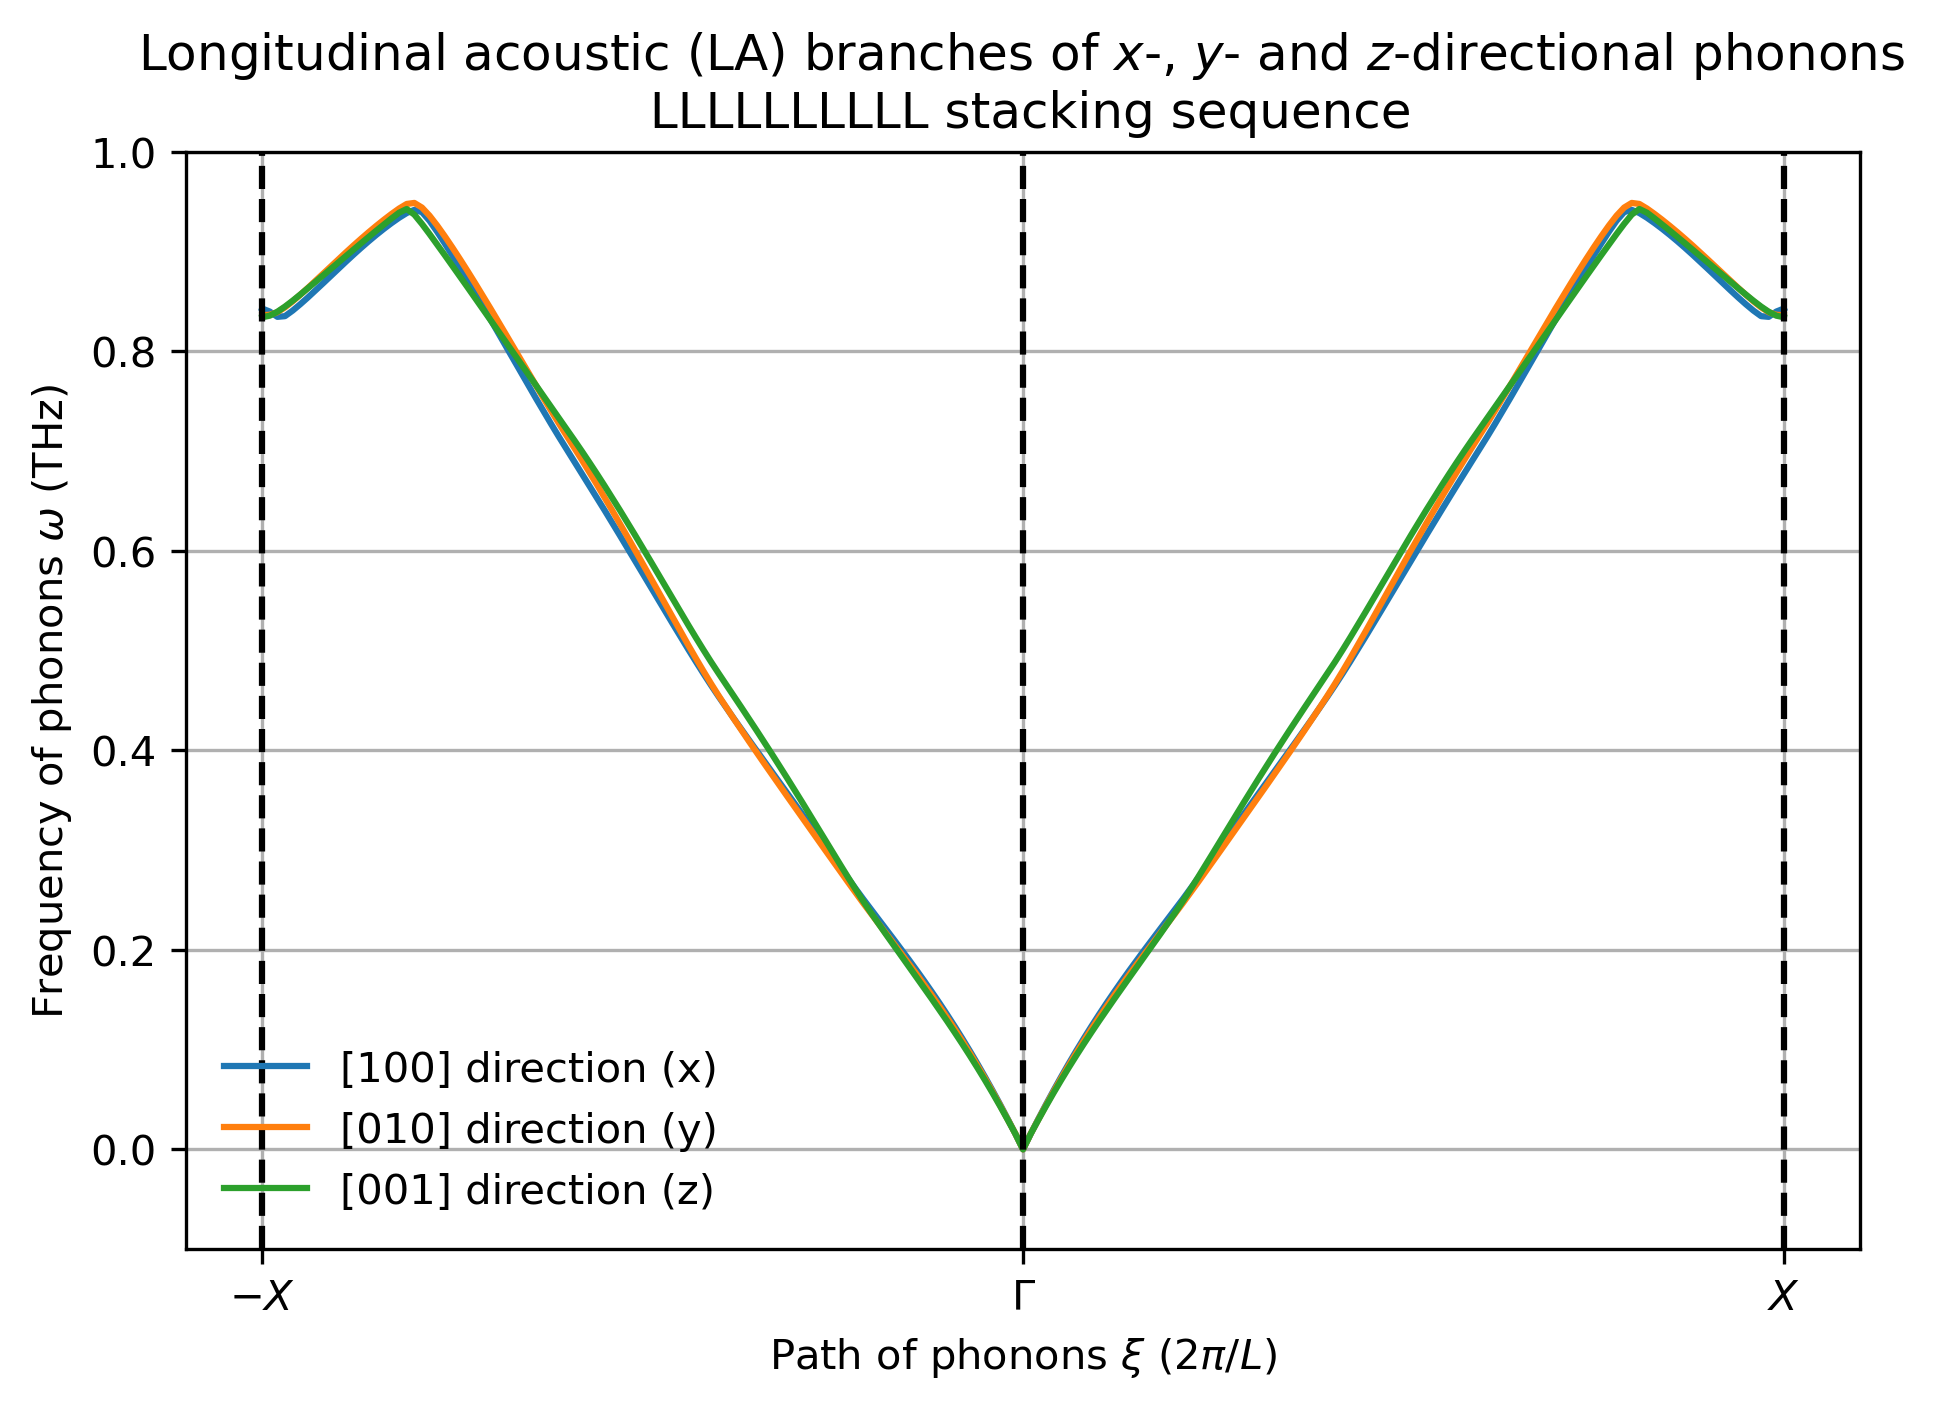

In [60]:
# Load path data for each path direction
data_x = np.loadtxt("LLLLLLLLLL_x.dat")
data_y = np.loadtxt("LLLLLLLLLL_y.dat")
data_z = np.loadtxt("LLLLLLLLLL_z.dat")

# Extract q, which gives us the path
q = data_x[:,3] # y and z should be equivalent here     
# And the frequencies, which are 4th column onwards in our data
freqs_x = data_x[:,4:]; freqs_y = data_y[:,4:]; freqs_z = data_z[:,4:]

# Extract the longitudinal acoustic branch, needed for the speed of sound
LA_x = freqs_x[:,2]
LA_y = freqs_y[:,2]
LA_z = freqs_z[:,2]

# Plot them
plt.plot(q, LA_x, label="[100] direction (x)")
plt.plot(q, LA_y, label="[010] direction (y)")
plt.plot(q, LA_z, label="[001] direction (z)")

# Assign gamma and X labels describing the path of phonons
mid = len(q) // 2
plt.xticks([q[0], q[mid], q[-1]], [r"$-X$", r"$\Gamma$", r"$X$"])

# Make it clearer
plt.axvline(q[0],  linestyle="--",color='black')
plt.axvline(q[mid], linestyle="--", color='black')
plt.axvline(q[-1], linestyle="--", color='black')

plt.xlabel(r"Path of phonons $\xi $ ($2 \pi / L$)")
plt.ylabel(r"Frequency of phonons $\omega$ (THz)")
plt.title("Longitudinal acoustic (LA) branches of $x$-, $y$- and $z$-directional phonons \n LLLLLLLLLL stacking sequence")
plt.legend()
plt.grid()
plt.ylim(-0.1,1)
plt.tight_layout()


## Monoatomic dispersion relation, -0.4X -> gamma -> 0.4X

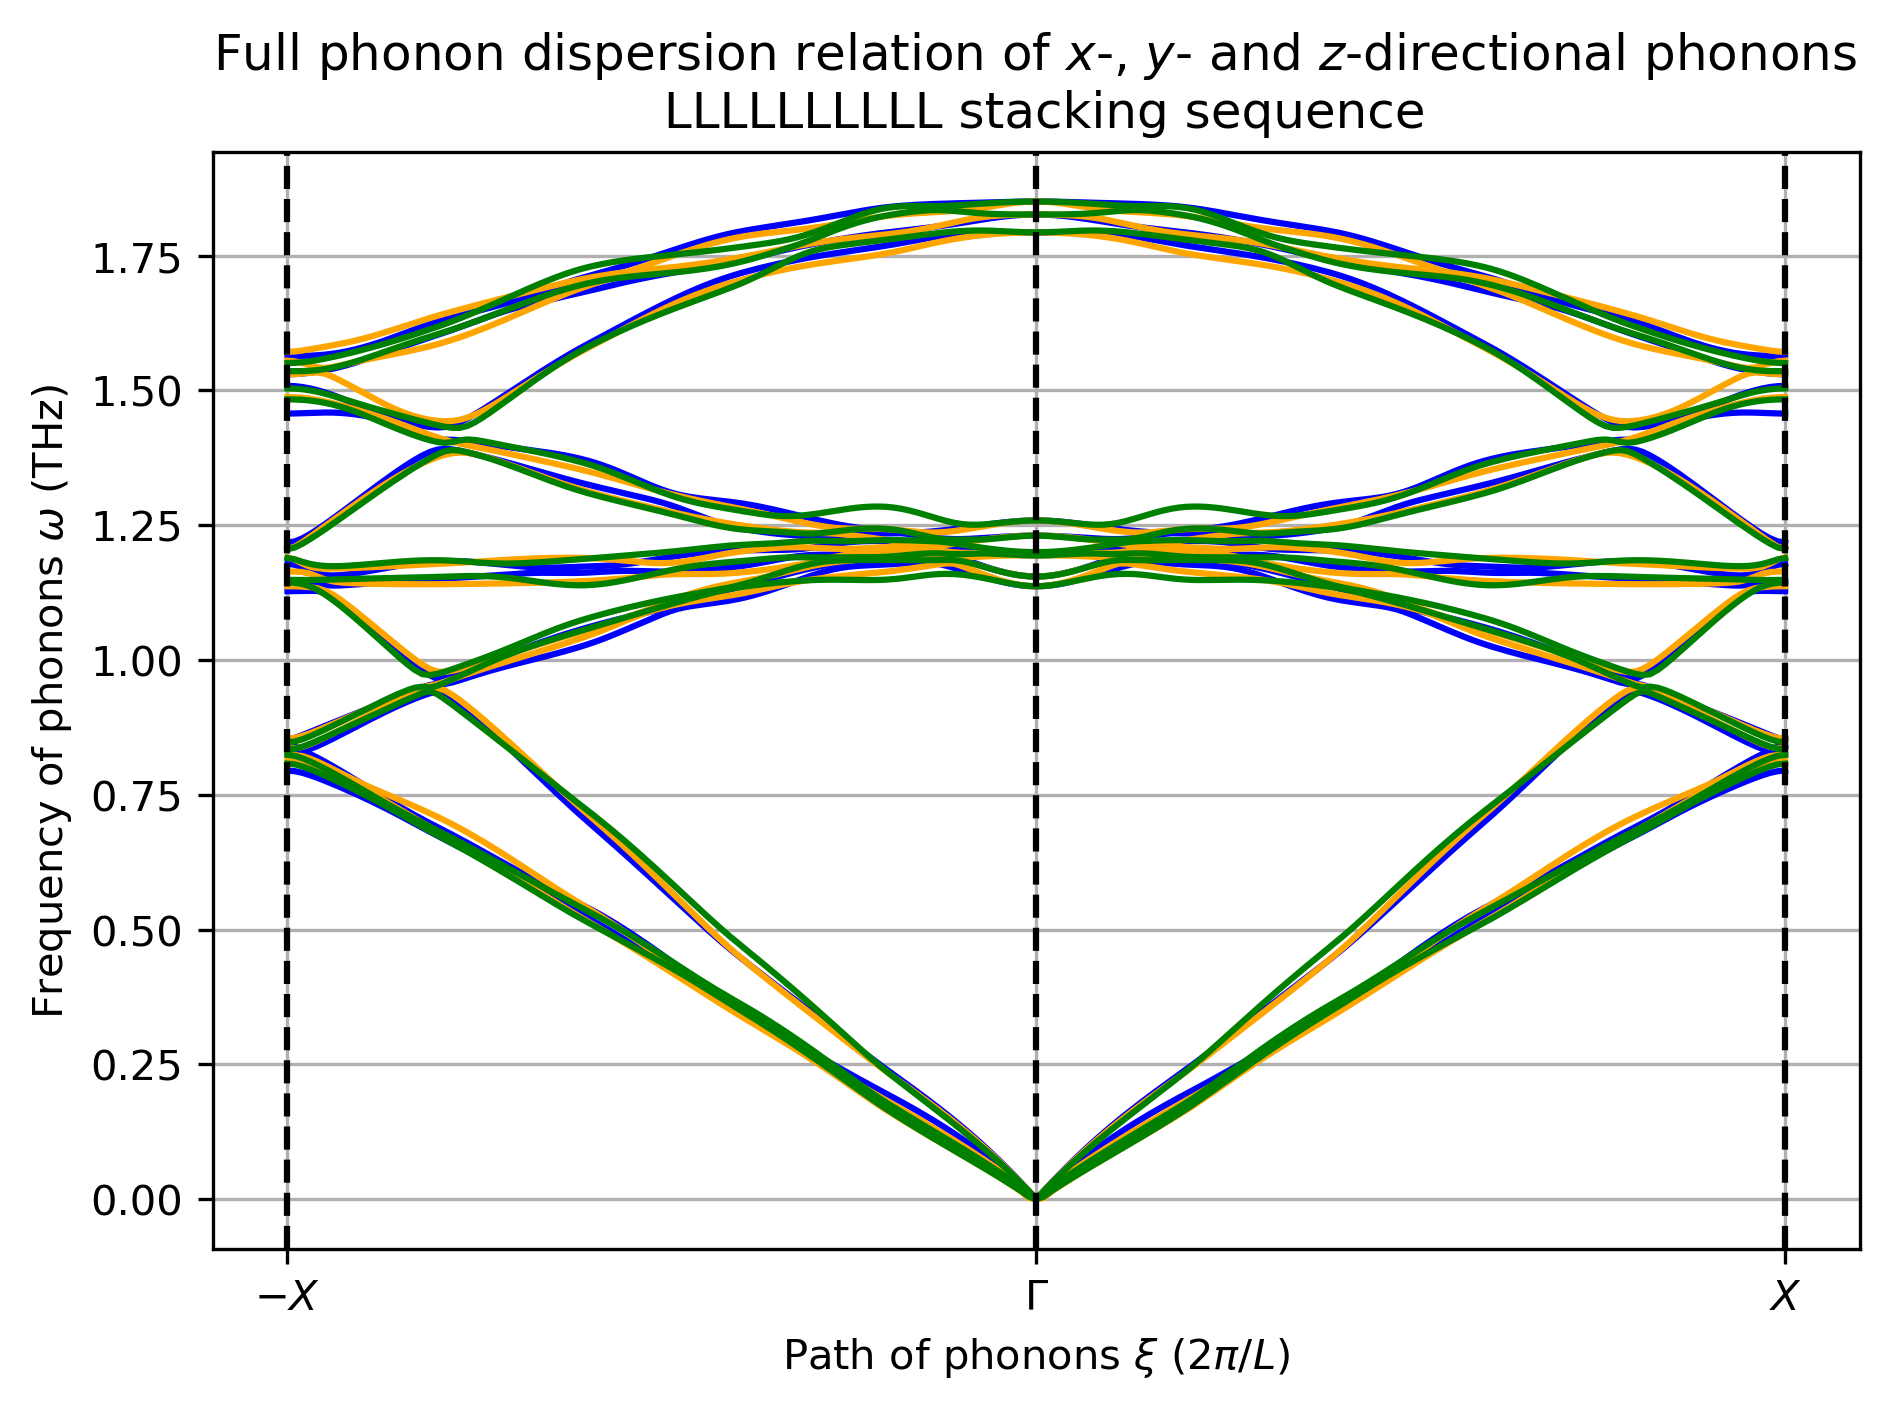

In [61]:
# Load path data for each path direction
data_x = np.loadtxt("LLLLLLLLLL_x.dat")
data_y = np.loadtxt("LLLLLLLLLL_y.dat")
data_z = np.loadtxt("LLLLLLLLLL_z.dat")

# Extract q, which gives us the path
q = data_x[:,3] # y and z should be equivalent here     
# And the frequencies, which are 4th column onwards in our data
freqs_x = data_x[:,4:]; freqs_y = data_y[:,4:]; freqs_z = data_z[:,4:]

# Plot them
plt.plot(q, freqs_x, color="blue")
plt.plot(q, freqs_y, color="orange")
plt.plot(q, freqs_z, color="green")

# Assign gamma and X labels describing the path of phonons
mid = len(q) // 2
plt.xticks([q[0], q[mid], q[-1]], [r"$-X$", r"$\Gamma$", r"$X$"])

# Make it clearer
plt.axvline(q[0],  linestyle="--",color='black')
plt.axvline(q[mid], linestyle="--", color='black')
plt.axvline(q[-1], linestyle="--", color='black')

plt.xlabel(r"Path of phonons $\xi $ ($2 \pi / L$)")
plt.ylabel(r"Frequency of phonons $\omega$ (THz)")
plt.title("Full phonon dispersion relation of $x$-, $y$- and $z$-directional phonons \n LLLLLLLLLL stacking sequence")
plt.grid()
plt.tight_layout()

## Monoatomic density of states

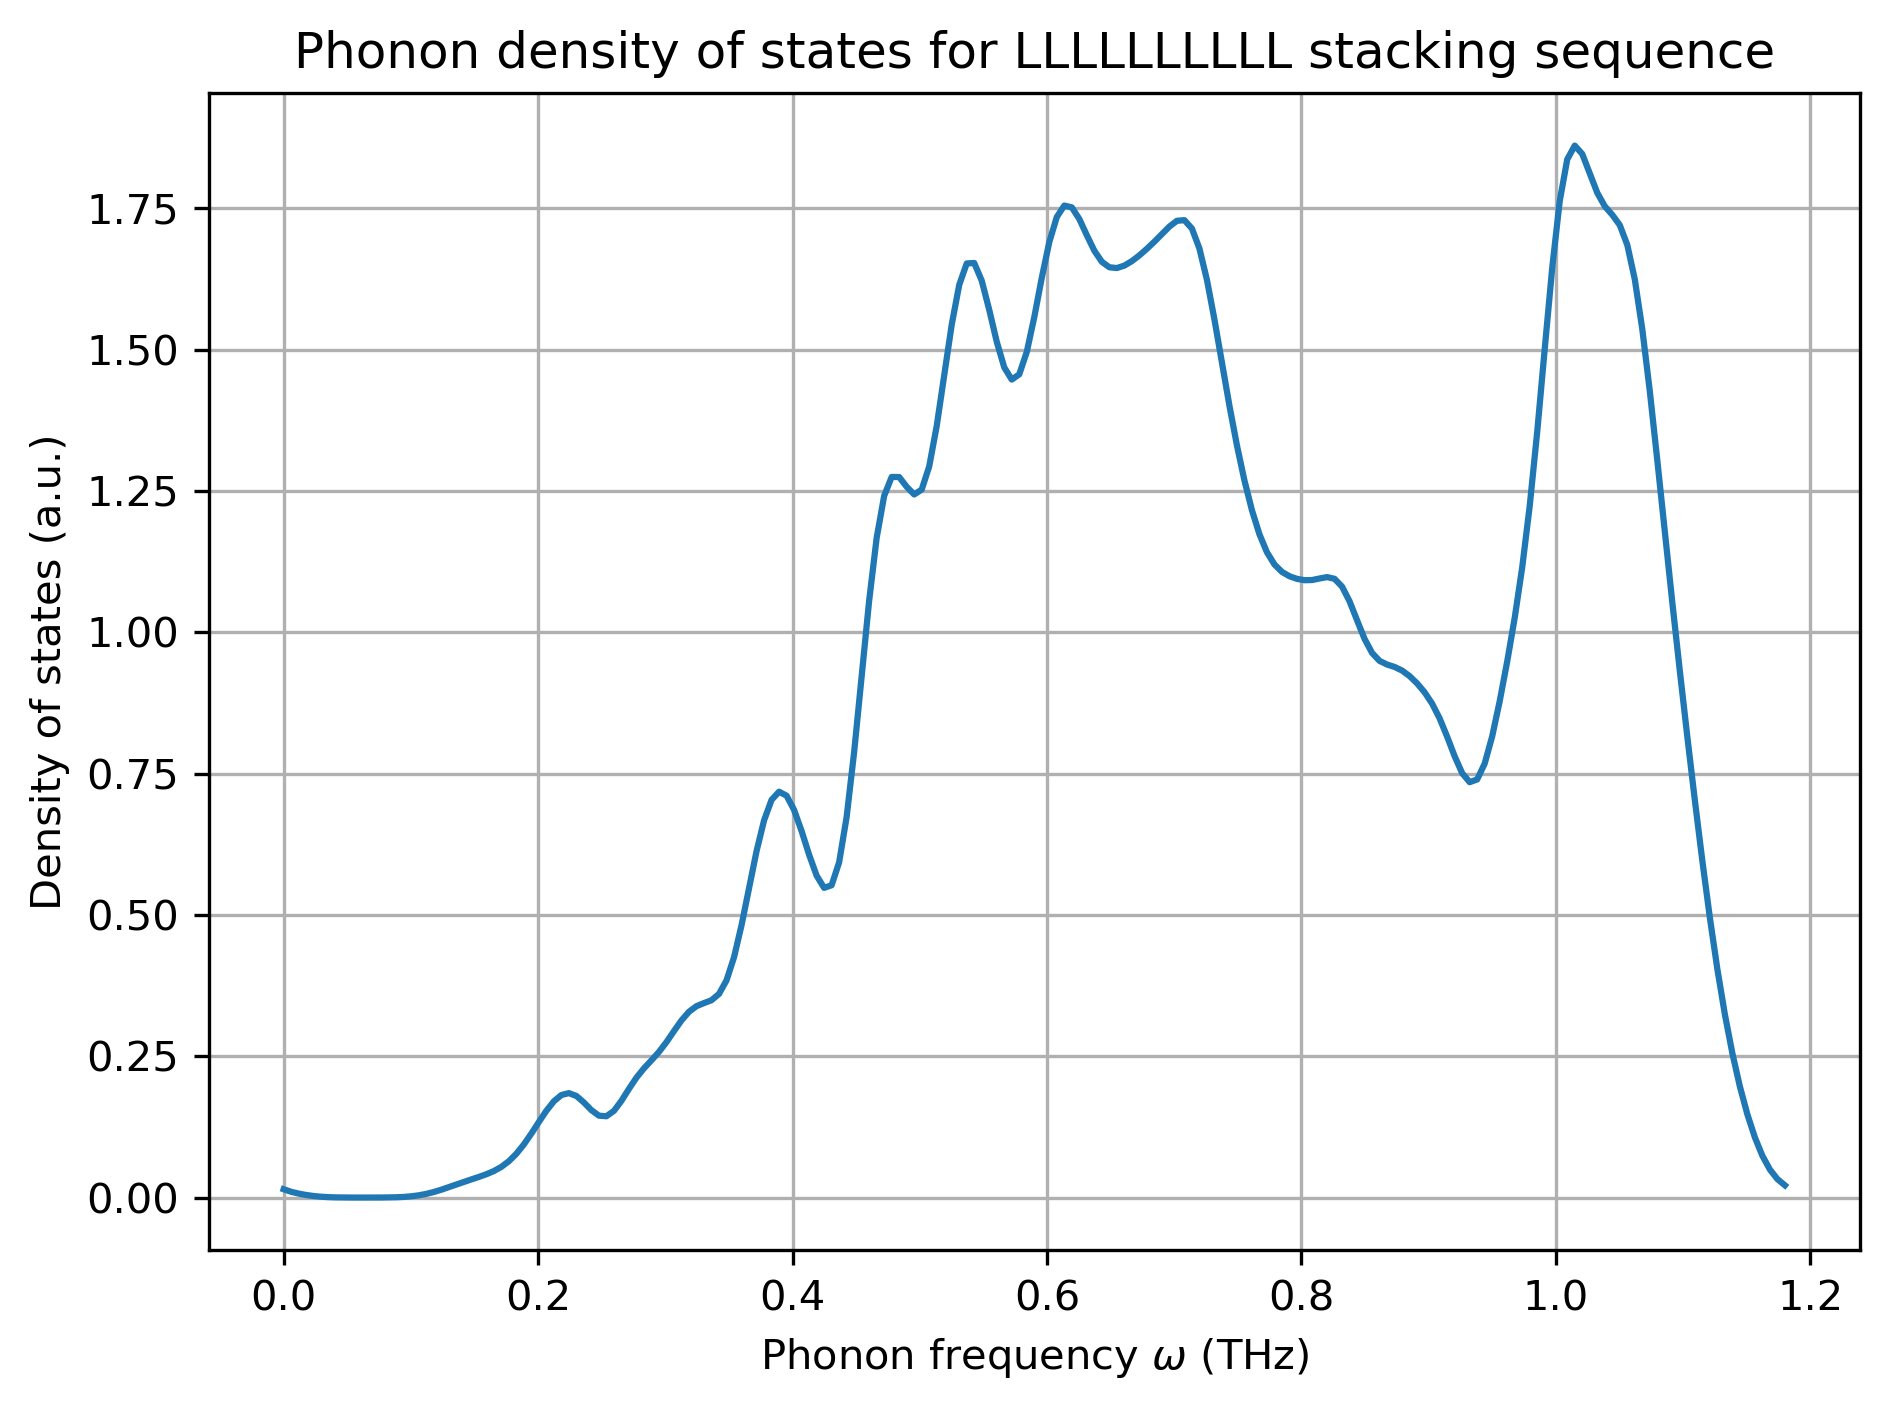

In [36]:
# Load path data for each path direction
data_dos = np.loadtxt("pdos_ordered.dat")

# Extract frequencies and density of states
freqs = data_dos[:,0]
DOS = data_dos[:,1]


# Plot them
plt.plot(freqs, DOS)

plt.xlabel(r"Phonon frequency $\omega$ (THz)")
plt.ylabel(r"Density of states (a.u.)")
plt.title("Phonon density of states for LLLLLLLLLL stacking sequence")
plt.grid()
plt.tight_layout()

## Diatomic case

In [62]:
def generate_FCC(Ncells, Nlayers, spacings):
    """Creates a face-centered cubic (FCC) structure.
    This specific function assumes one type of atom only.
    
    Inputs:
    Ncells - number of cells as a two-dimensional NumPy vector [Nx, Nz]
    Nlayers - number of layers along y (integer)
    spacings - lattice constant / spacing between cells
    
    Outputs:
    positions - two-dimensional NumPy array of positions [x,y,z] per atom
    type_atoms - one-dimensional NumPy array labelling atom types as integers"""
    # Create storage arrays
    positions = []
    atom_types = []

    # Extract spacing and cells
    x_spacing, y_spacing, z_spacing = spacings
    Ncells_x, Ncells_z = Ncells

    # Determine Cartesian range of atoms
    x_range, z_range = range(2*Ncells_x), range(2*Ncells_z) 
    y_range = range(0, 2*Nlayers)

    # Loop over the range of x,y,z
    for x,y,z in itertools.product(x_range, y_range, z_range):
        # First layer: y=0
        if (x%2 == 0 and y%2 == 0 and z%2 == 0):
            x, z = x*0.5*x_spacing, z*0.5*z_spacing
            y = (y//2)*y_spacing
            # Append positions and types
            positions.append([x,y,z])
            atom_types.append(int(1))

        # Second layer: y=1
        elif (x%2 == 0 and y%2 == 1 and z%2 == 1):
            x, z = x*0.5*x_spacing, z*0.5*z_spacing
            y = (y//2 + 0.5)*y_spacing
            # Append positions and types
            positions.append([x,y,z])
            atom_types.append(int(2))

        # First layer again (sorry): y=0
        elif (x%2 == 1 and y%2 == 0 and z%2 == 1):
            x, z = x*0.5*x_spacing, z*0.5*z_spacing
            y = (y//2)*y_spacing
            # Append positions and types
            positions.append([x,y,z])
            atom_types.append(int(1))

        # Second layer: y=1
        elif (x%2 == 1 and y%2 == 1 and z%2 == 0):
            x, z = x*0.5*x_spacing, z*0.5*z_spacing
            y = (y//2 + 0.5)*y_spacing
            # Append positions and types
            positions.append([x,y,z])
            atom_types.append(int(2))
                                    
    # Convert lists to arrays for plotting & return
    positions = np.array(positions)
    atom_types = np.array(atom_types)
    
    return positions, atom_types

In [63]:
# Investigate 2x2xn sizes, where n is the amount of layers
Ncells = np.array([5,5])
Nlayers = 5
spacings = np.array([5.376,5.376,5.376])
update_masses("fixphonon.txt", 39.948, 100.0)

# Extract positions
positions, atom_types = generate_FCC(Ncells, Nlayers, spacings)

# Count amount of occurences of type 1 and 2
atom_types = np.asarray(atom_types)
unique, counts = np.unique(atom_types, return_counts=True)
dict(zip(unique, counts))

{np.int64(1): np.int64(250), np.int64(2): np.int64(250)}

In [64]:
generate_map_in(Ncells, Nlayers)
layered_datafile_creation(Ncells, Nlayers, spacings)

## y-directional phonon travel: Full phonon dispersion relation

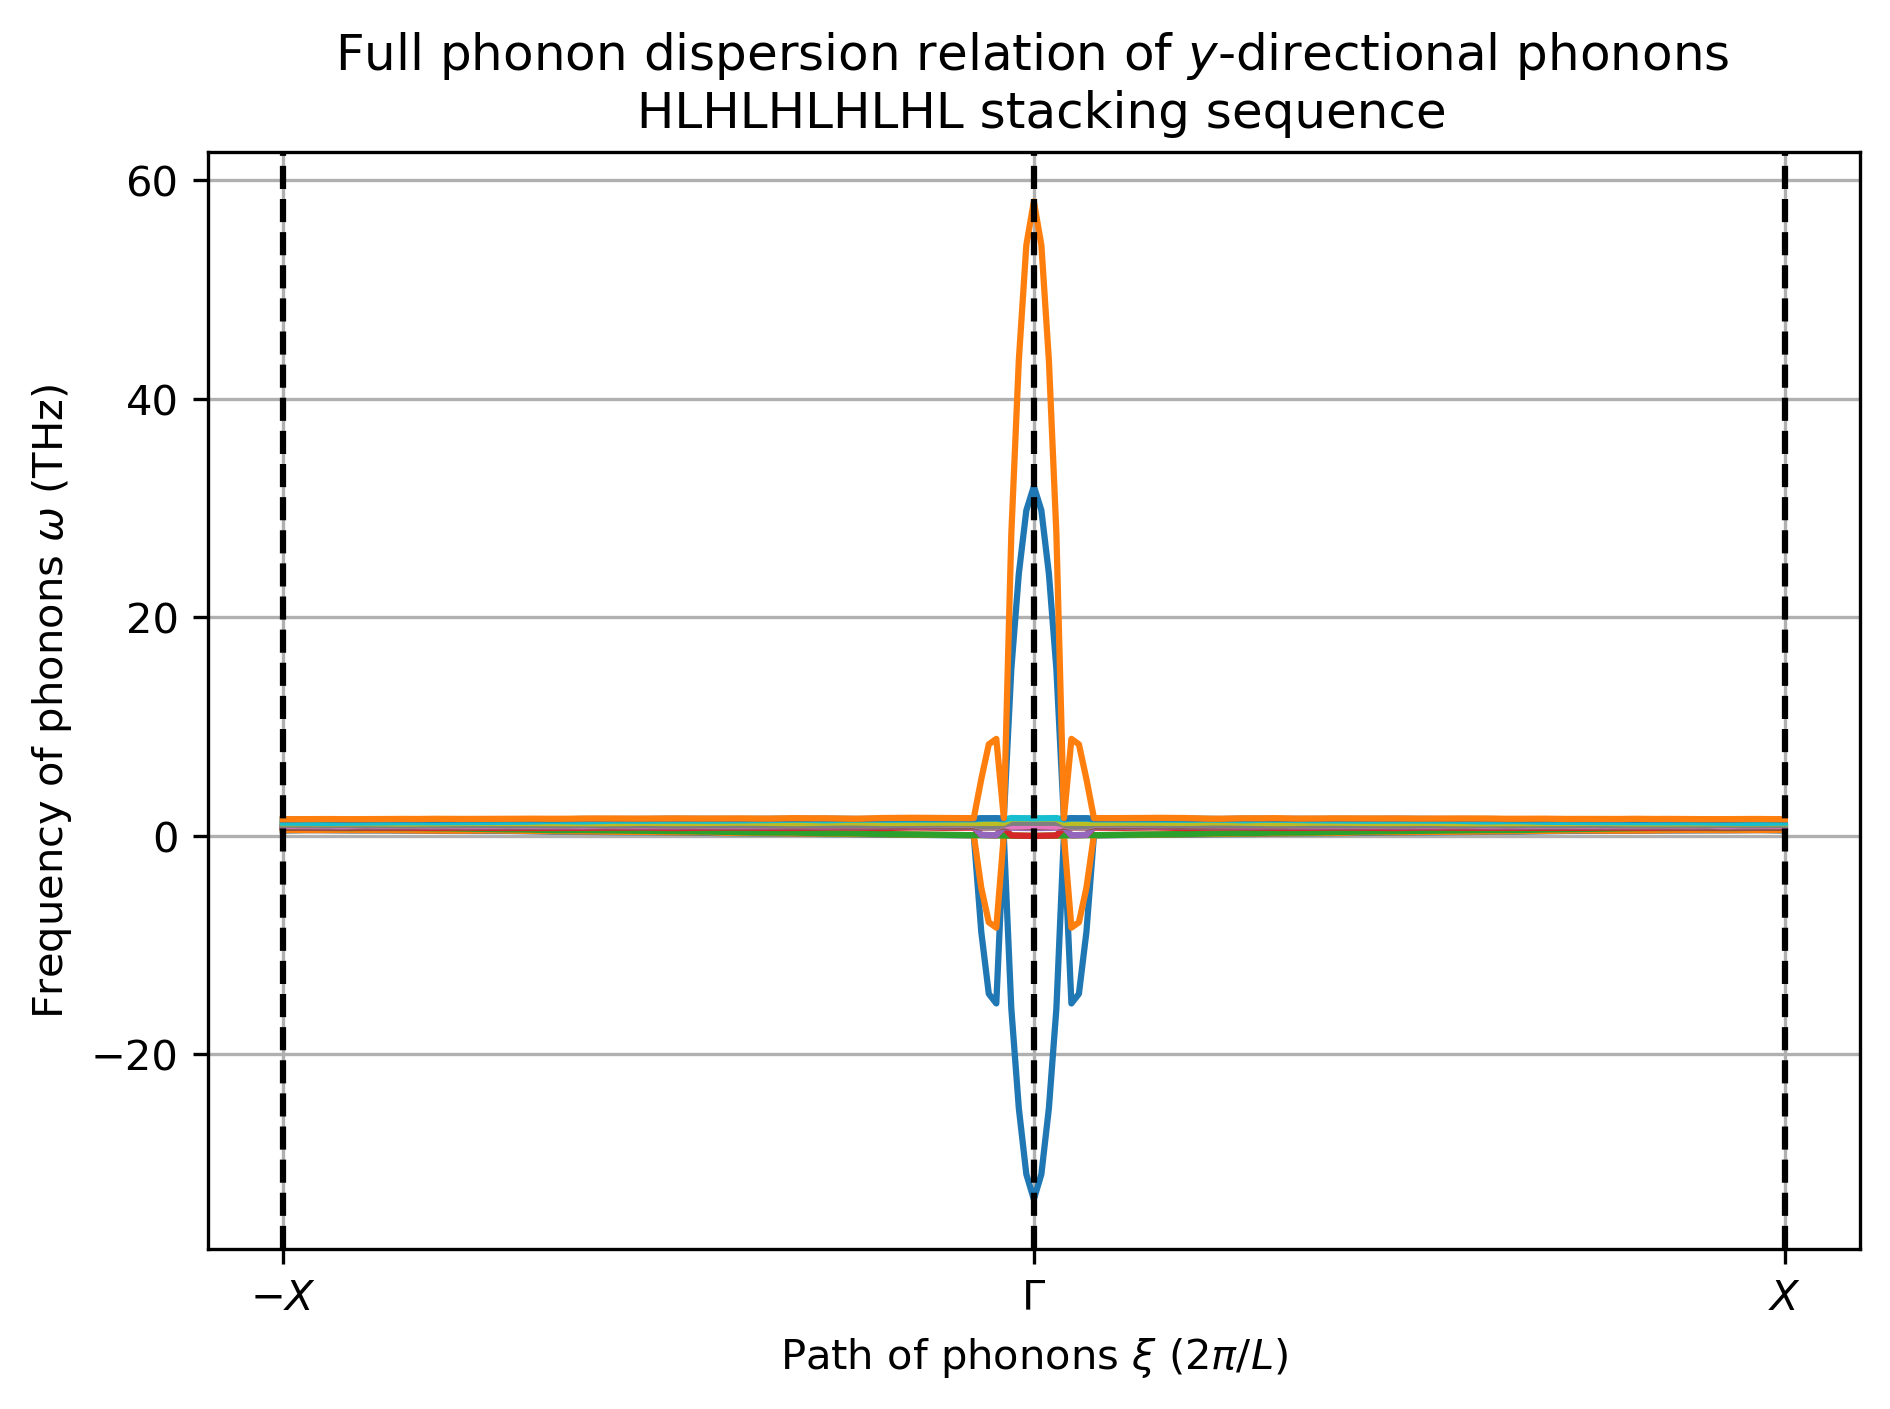

In [12]:
data_y = np.loadtxt("HLHLHLHLHL_y.dat")
# Extract q, which gives us the path
q = data_y[:,3] # y and z should be equivalent here     
# And the frequencies, which are 4th column onwards in our data
freqs_y = data_y[:,4:]

plt.plot(q,freqs_y)
#plt.plot(q, LA_y, label="[010] direction (y)")

# Assign gamma and X labels describing the path of phonons
mid = len(q) // 2
plt.xticks([q[0], q[mid], q[-1]], [r"$-X$", r"$\Gamma$", r"$X$"])

# Make it clearer
plt.axvline(q[0],  linestyle="--",color='black')
plt.axvline(q[mid], linestyle="--", color='black')
plt.axvline(q[-1], linestyle="--", color='black')

plt.xlabel(r"Path of phonons $\xi $ ($2 \pi / L$)")
plt.ylabel(r"Frequency of phonons $\omega$ (THz)")
plt.title("Full phonon dispersion relation of $y$-directional phonons \n HLHLHLHLHL stacking sequence")
plt.grid()
#plt.ylim(-0.1,1)
plt.tight_layout()

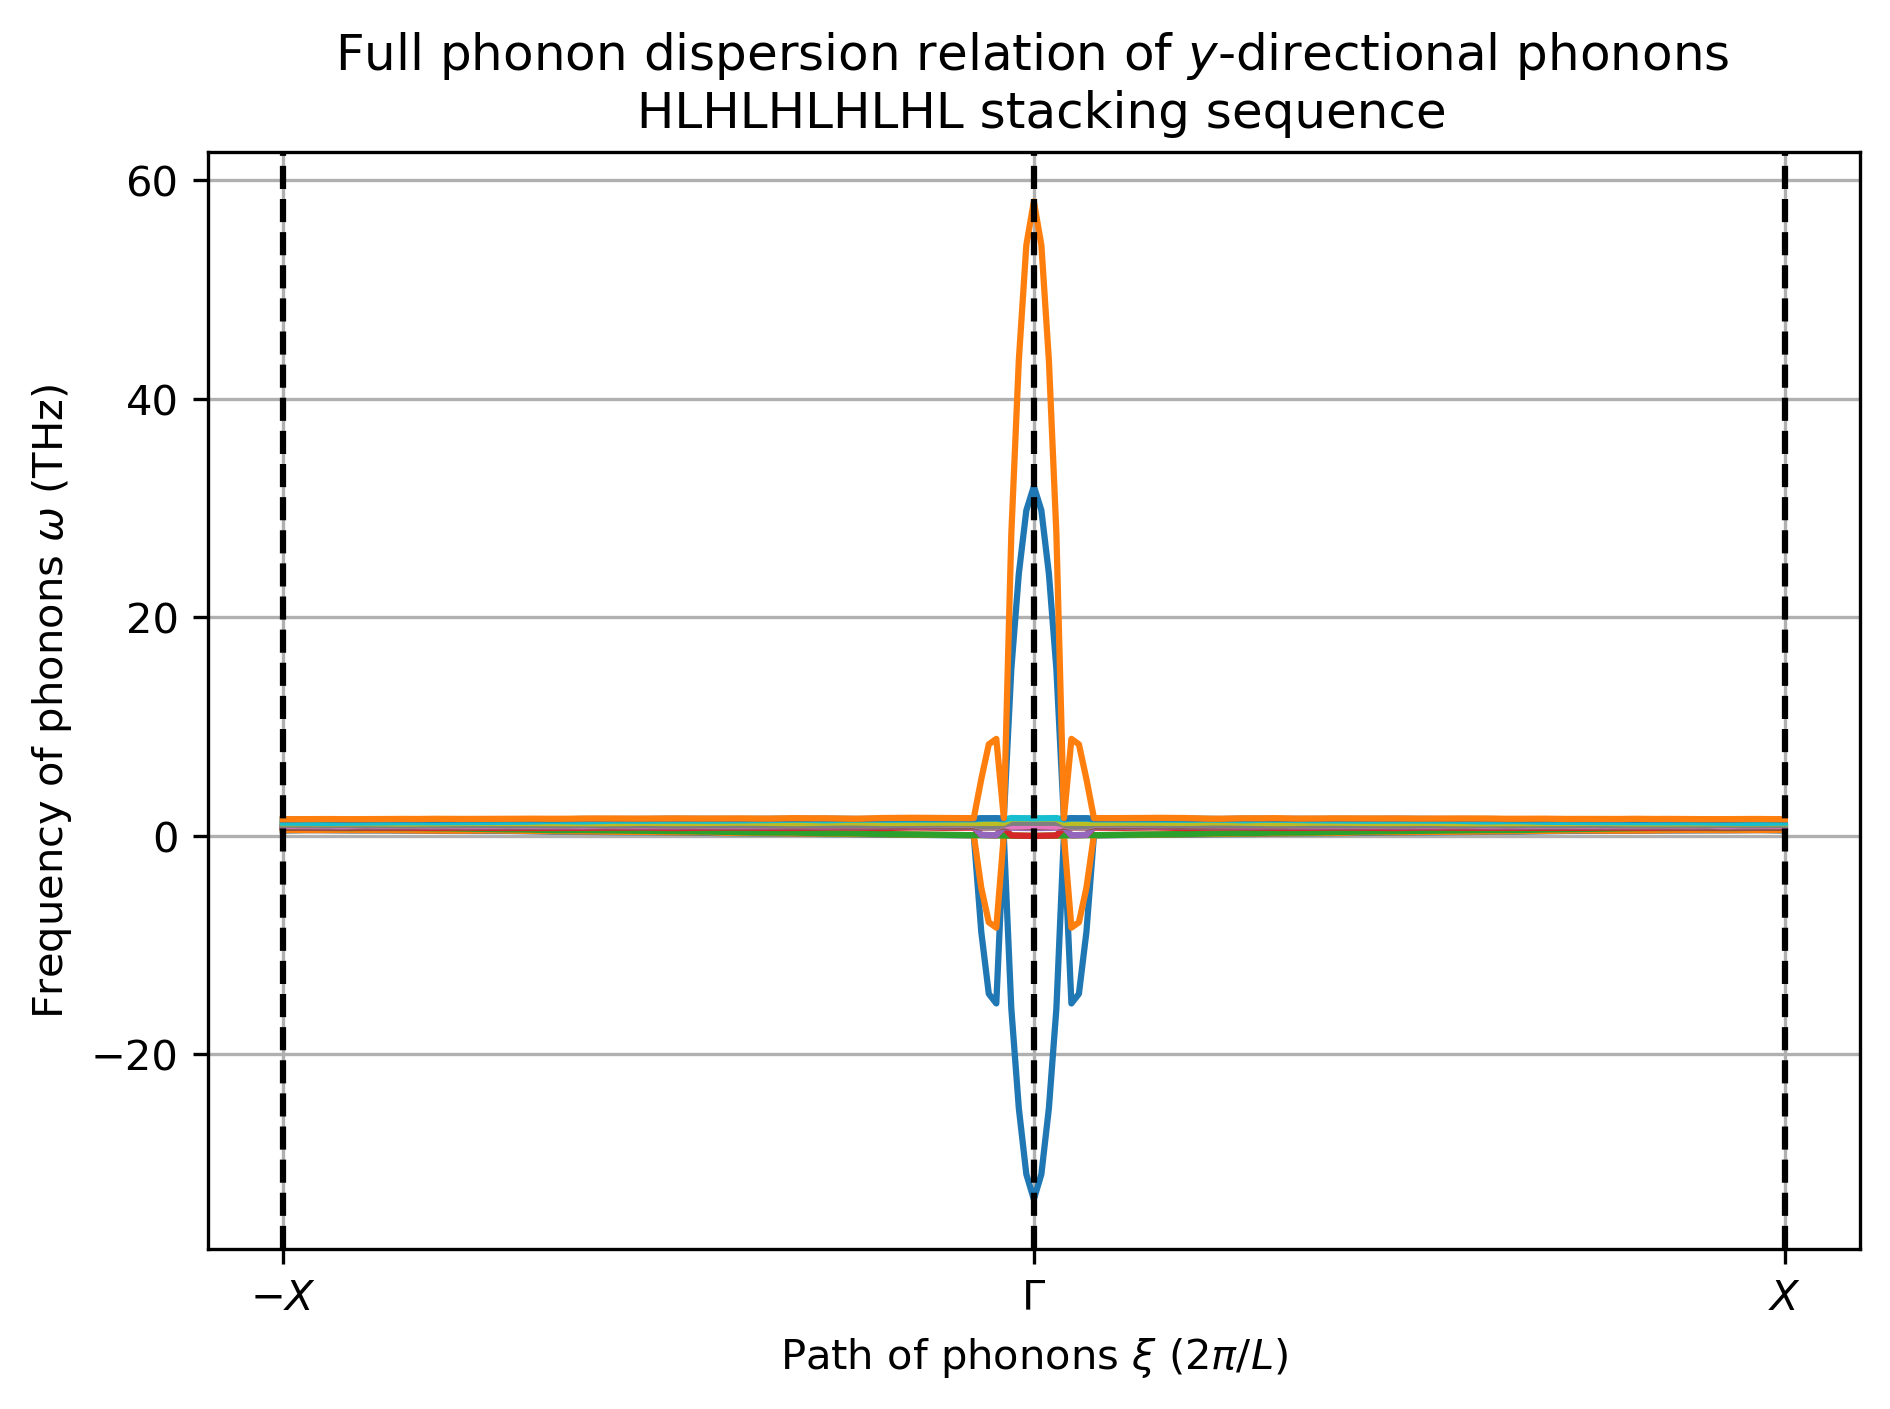

In [14]:
data_y = np.loadtxt("HLHLHLHLHL_y.dat")
# Extract q, which gives us the path
q = data_y[:,3] # y and z should be equivalent here     
# And the frequencies, which are 4th column onwards in our data
freqs_y = data_y[:,4:]

plt.plot(q,freqs_y)
#plt.plot(q, LA_y, label="[010] direction (y)")

# Assign gamma and X labels describing the path of phonons
mid = len(q) // 2
plt.xticks([q[0], q[mid], q[-1]], [r"$-X$", r"$\Gamma$", r"$X$"])

# Make it clearer
plt.axvline(q[0],  linestyle="--",color='black')
plt.axvline(q[mid], linestyle="--", color='black')
plt.axvline(q[-1], linestyle="--", color='black')

plt.xlabel(r"Path of phonons $\xi $ ($2 \pi / L$)")
plt.ylabel(r"Frequency of phonons $\omega$ (THz)")
plt.title("Full phonon dispersion relation of $y$-directional phonons \n HLHLHLHLHL stacking sequence")
plt.grid()
#plt.ylim(-0.1,1)
plt.tight_layout()

## Plotting only some frequencies

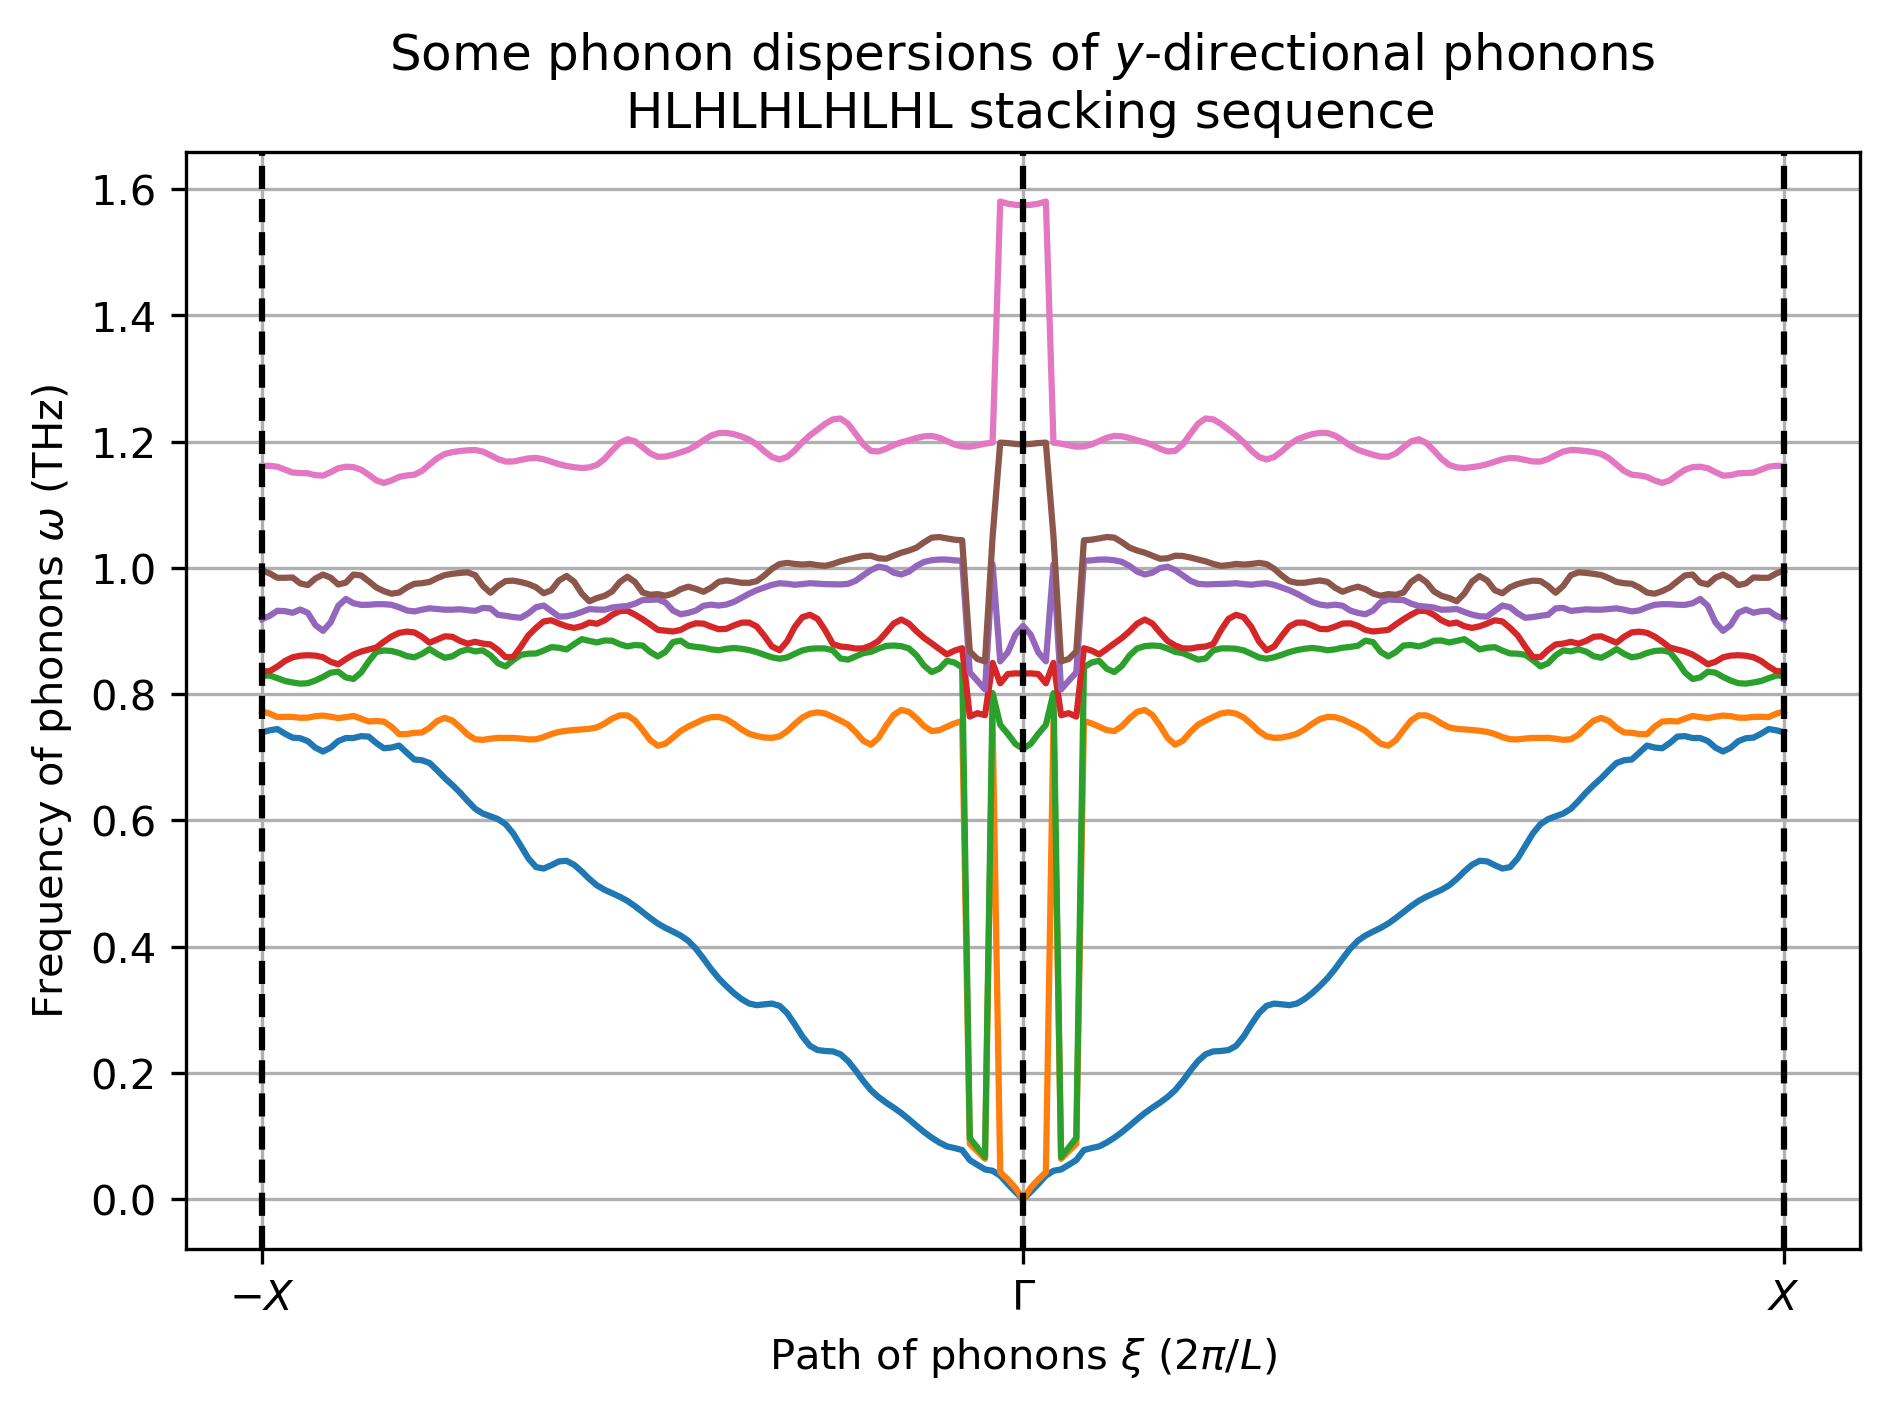

In [17]:
#data_y = np.loadtxt("HLHLHLHLHL_y.dat")
# Extract q, which gives us the path
q = data_y[:,3] # y and z should be equivalent here     
# And the frequencies, which are 4th column onwards in our data
freqs_y = data_y[:,4:]

plt.plot(q,freqs_y[:,2:9])
#plt.plot(q, LA_y, label="[010] direction (y)")

# Assign gamma and X labels describing the path of phonons
mid = len(q) // 2
plt.xticks([q[0], q[mid], q[-1]], [r"$-X$", r"$\Gamma$", r"$X$"])

# Make it clearer
plt.axvline(q[0],  linestyle="--",color='black')
plt.axvline(q[mid], linestyle="--", color='black')
plt.axvline(q[-1], linestyle="--", color='black')

plt.xlabel(r"Path of phonons $\xi $ ($2 \pi / L$)")
plt.ylabel(r"Frequency of phonons $\omega$ (THz)")
plt.title("Some phonon dispersions of $y$-directional phonons \n HLHLHLHLHL stacking sequence")
plt.grid()
#plt.ylim(-0.1,1)
plt.tight_layout()

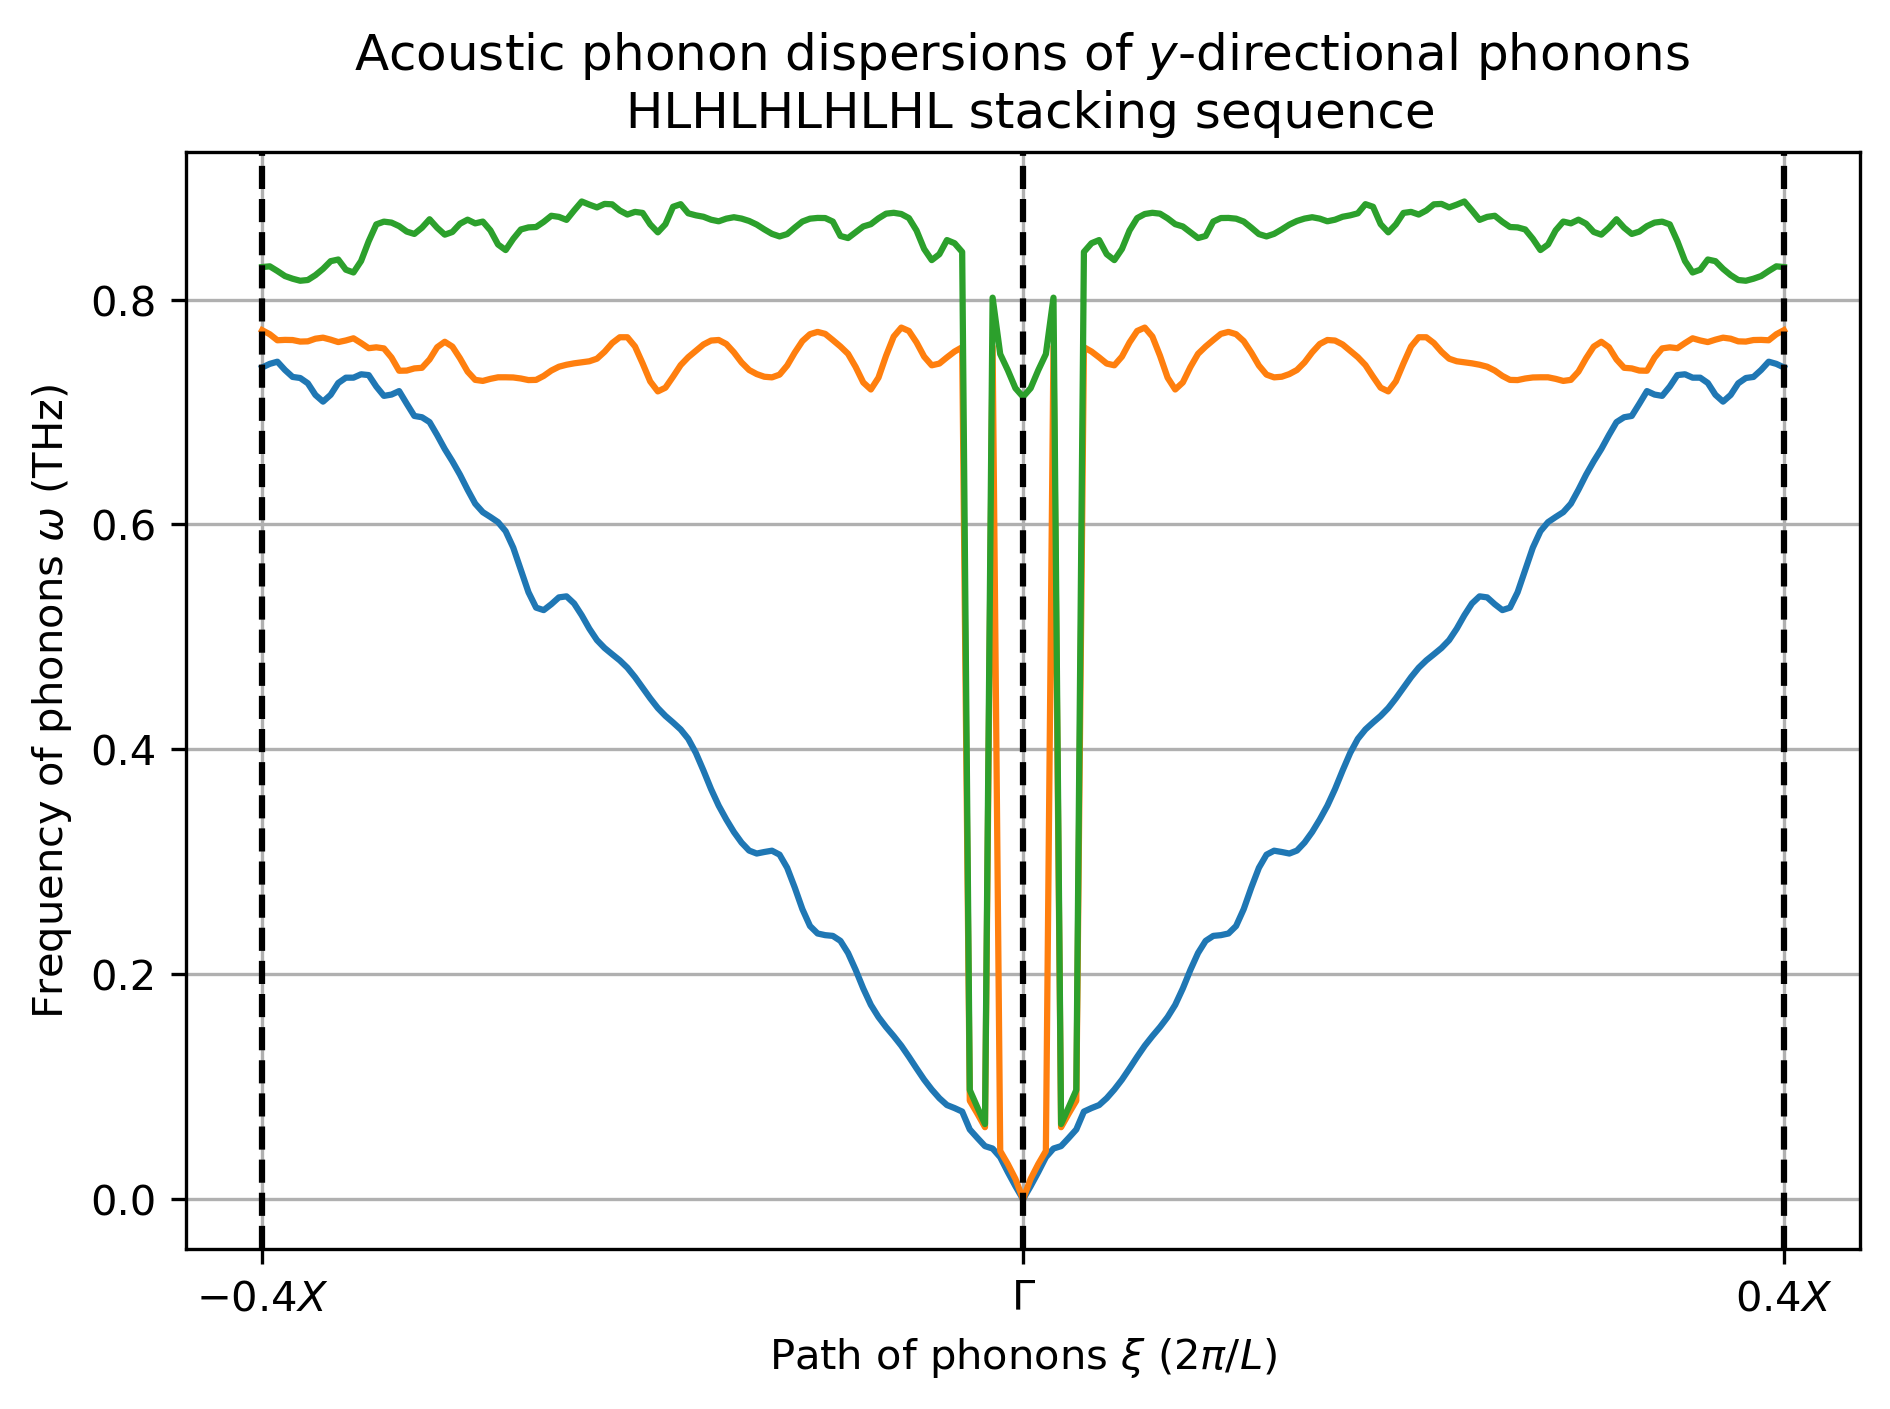

In [18]:
data_y = np.loadtxt("HLHLHLHLHL_y.dat")
# Extract q, which gives us the path
q = data_y[:,3] # y and z should be equivalent here     
# And the frequencies, which are 4th column onwards in our data
freqs_y = data_y[:,4:]

plt.plot(q,freqs_y[:,2:5])
#plt.plot(q, LA_y, label="[010] direction (y)

# Assign gamma and X labels describing the path of phonons
mid = len(q) // 2
plt.xticks([q[0], q[mid], q[-1]], [r"$-0.4X$", r"$\Gamma$", r"$0.4X$"])

# Make it clearer
plt.axvline(q[0],  linestyle="--",color='black')
plt.axvline(q[mid], linestyle="--", color='black')
plt.axvline(q[-1], linestyle="--", color='black')

plt.xlabel(r"Path of phonons $\xi $ ($2 \pi / L$)")
plt.ylabel(r"Frequency of phonons $\omega$ (THz)")
plt.title("Acoustic phonon dispersions of $y$-directional phonons \n HLHLHLHLHL stacking sequence")
plt.grid()
#plt.ylim(-0.1,1)
plt.tight_layout()

## Ok, that was along the disordered direction, surely its not the same for the ordered directions?

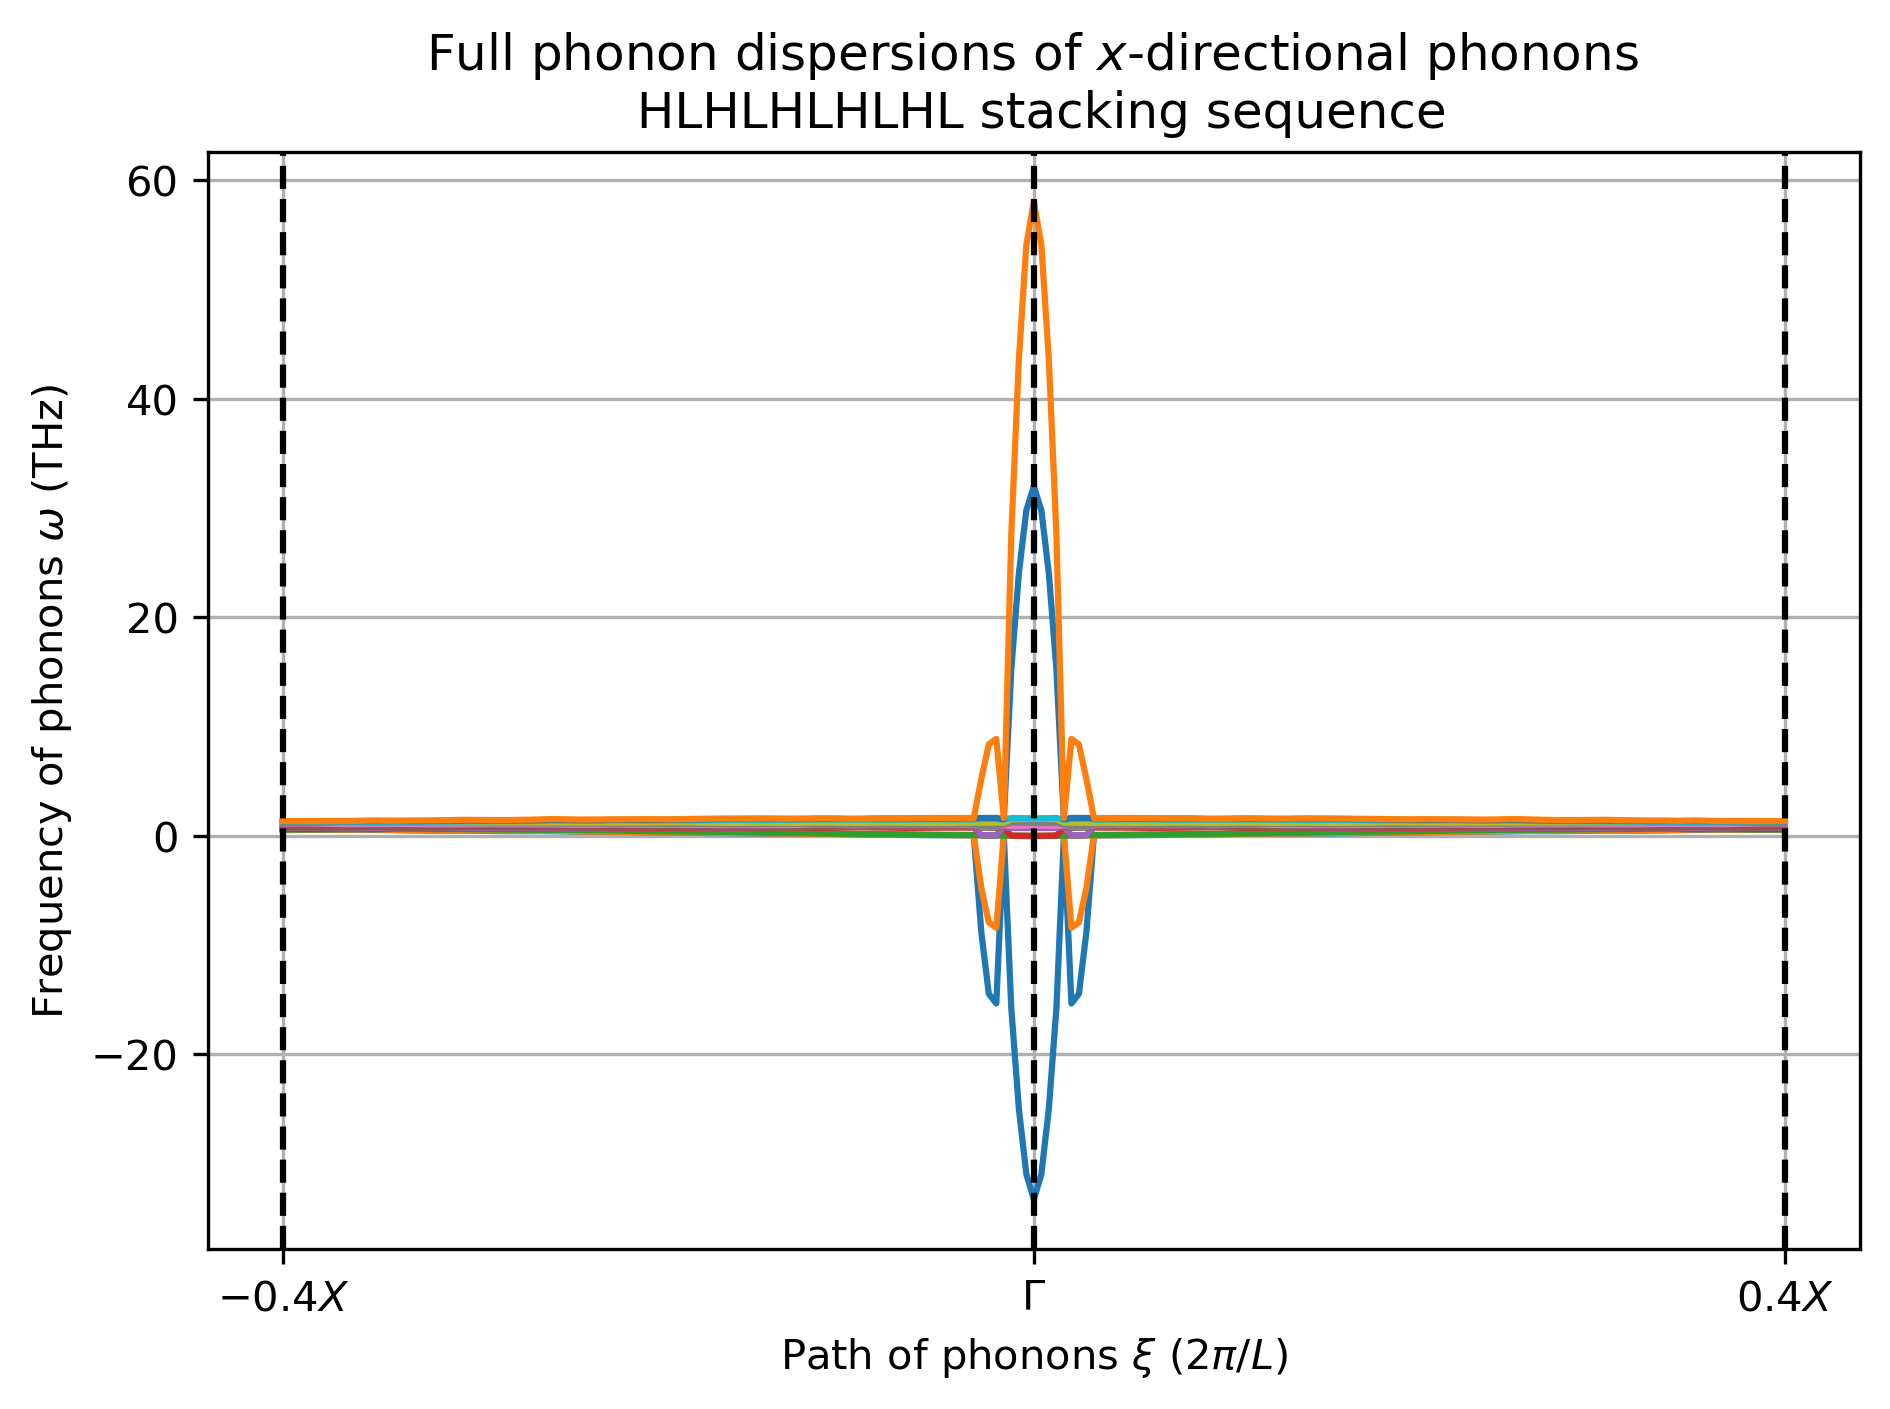

In [19]:
data_x = np.loadtxt("HLHLHLHLHL_x.dat")
# Extract q, which gives us the path
q = data_x[:,3] # y and z should be equivalent here     
# And the frequencies, which are 4th column onwards in our data
freqs_x = data_x[:,4:]

plt.plot(q,freqs_x)

# Assign gamma and X labels describing the path of phonons
mid = len(q) // 2
plt.xticks([q[0], q[mid], q[-1]], [r"$-0.4X$", r"$\Gamma$", r"$0.4X$"])

# Make it clearer
plt.axvline(q[0],  linestyle="--",color='black')
plt.axvline(q[mid], linestyle="--", color='black')
plt.axvline(q[-1], linestyle="--", color='black')

plt.xlabel(r"Path of phonons $\xi $ ($2 \pi / L$)")
plt.ylabel(r"Frequency of phonons $\omega$ (THz)")
plt.title("Full phonon dispersions of $x$-directional phonons \n HLHLHLHLHL stacking sequence")
plt.grid()
#plt.ylim(-0.1,1)
plt.tight_layout()

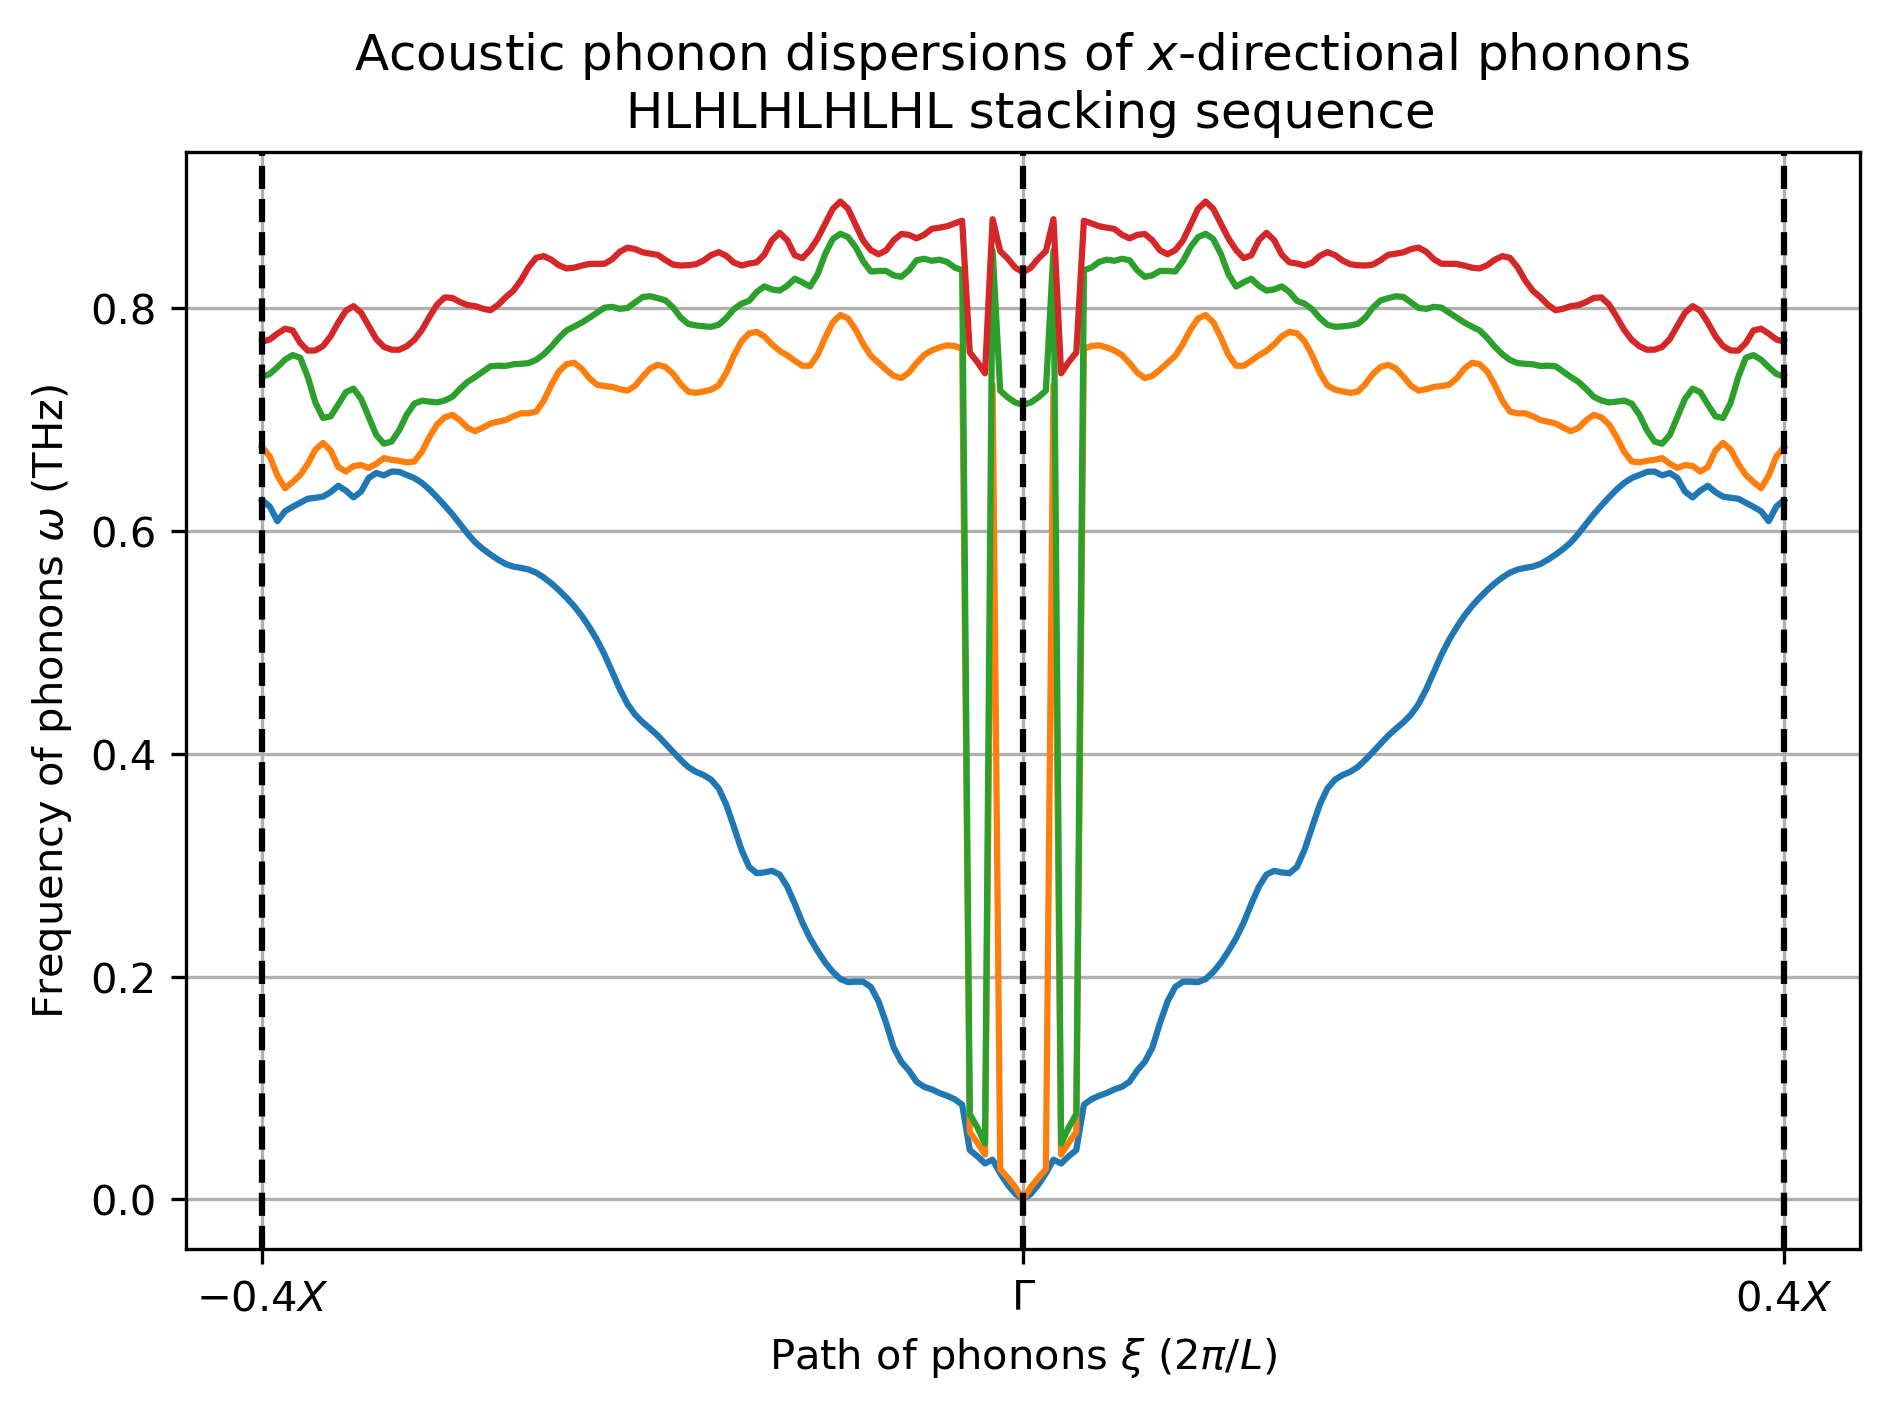

In [23]:
data_x = np.loadtxt("HLHLHLHLHL_x.dat")
# Extract q, which gives us the path
q = data_x[:,3] # y and z should be equivalent here     
# And the frequencies, which are 4th column onwards in our data
freqs_x = data_x[:,4:]

plt.plot(q,freqs_x[:,2:6])
#plt.plot(q, LA_y, label="[010] direction (y)")

# Assign gamma and X labels describing the path of phonons
mid = len(q) // 2
plt.xticks([q[0], q[mid], q[-1]], [r"$-0.4X$", r"$\Gamma$", r"$0.4X$"])

# Make it clearer
plt.axvline(q[0],  linestyle="--",color='black')
plt.axvline(q[mid], linestyle="--", color='black')
plt.axvline(q[-1], linestyle="--", color='black')

plt.xlabel(r"Path of phonons $\xi $ ($2 \pi / L$)")
plt.ylabel(r"Frequency of phonons $\omega$ (THz)")
plt.title("Acoustic phonon dispersions of $x$-directional phonons \n HLHLHLHLHL stacking sequence")
plt.grid()
#plt.ylim(-0.1,1)
plt.tight_layout()

## Does z show the same issue?

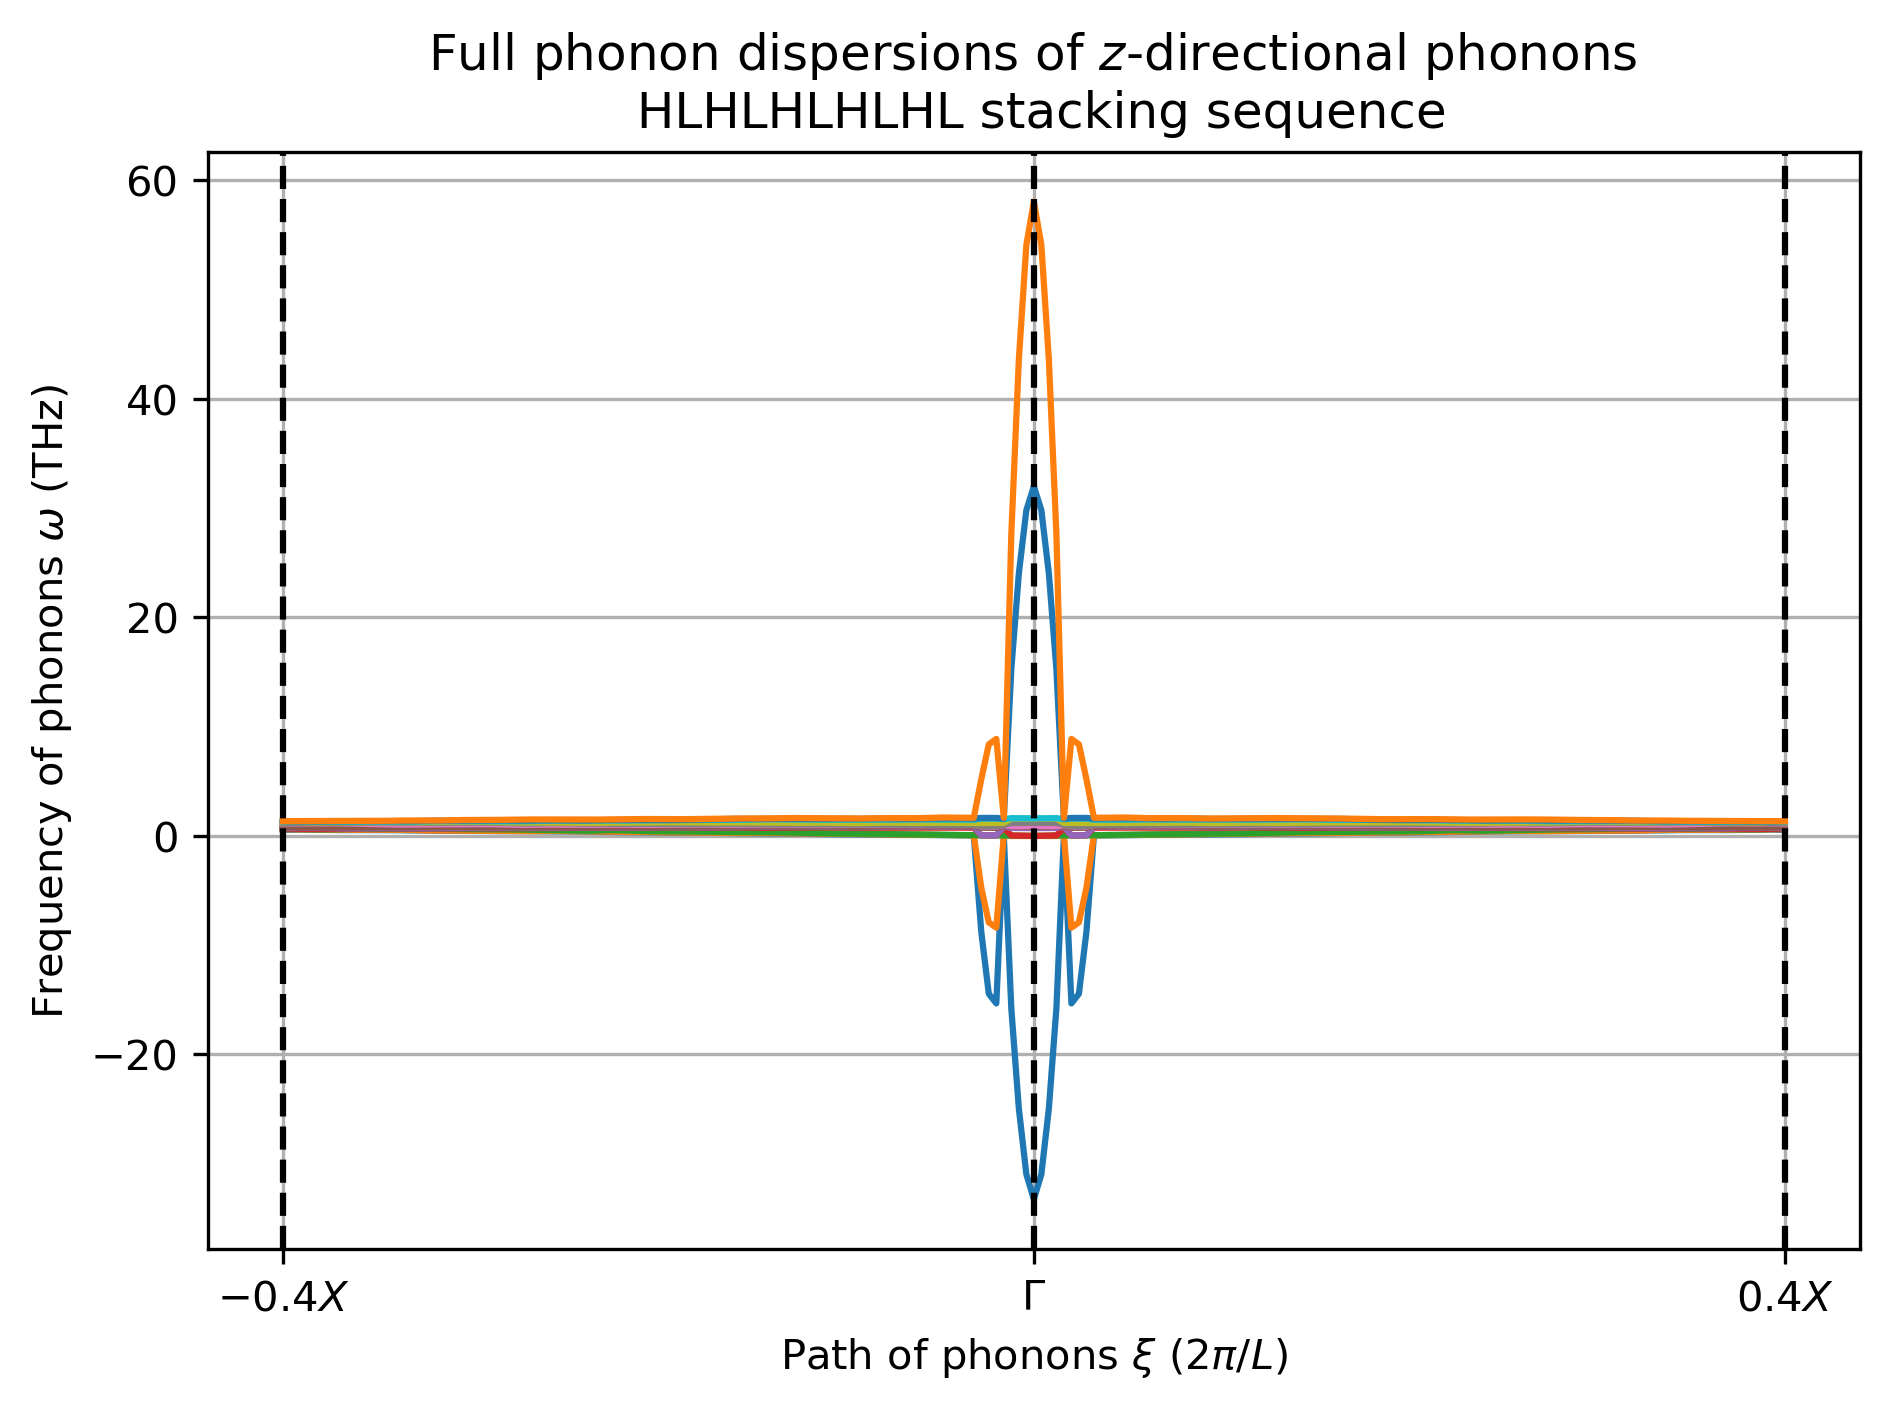

In [24]:
data_z = np.loadtxt("HLHLHLHLHL_z.dat")
# Extract q, which gives us the path
q = data_z[:,3] # y and z should be equivalent here     
# And the frequencies, which are 4th column onwards in our data
freqs_z = data_z[:,4:]

plt.plot(q,freqs_z[:])
#plt.plot(q, LA_y, label="[010] direction (y)")

# Assign gamma and X labels describing the path of phonons
mid = len(q) // 2
plt.xticks([q[0], q[mid], q[-1]], [r"$-0.4X$", r"$\Gamma$", r"$0.4X$"])

# Make it clearer
plt.axvline(q[0],  linestyle="--",color='black')
plt.axvline(q[mid], linestyle="--", color='black')
plt.axvline(q[-1], linestyle="--", color='black')

plt.xlabel(r"Path of phonons $\xi $ ($2 \pi / L$)")
plt.ylabel(r"Frequency of phonons $\omega$ (THz)")
plt.title("Full phonon dispersions of $z$-directional phonons \n HLHLHLHLHL stacking sequence")
plt.grid()
#plt.ylim(-0.1,1)
plt.tight_layout()

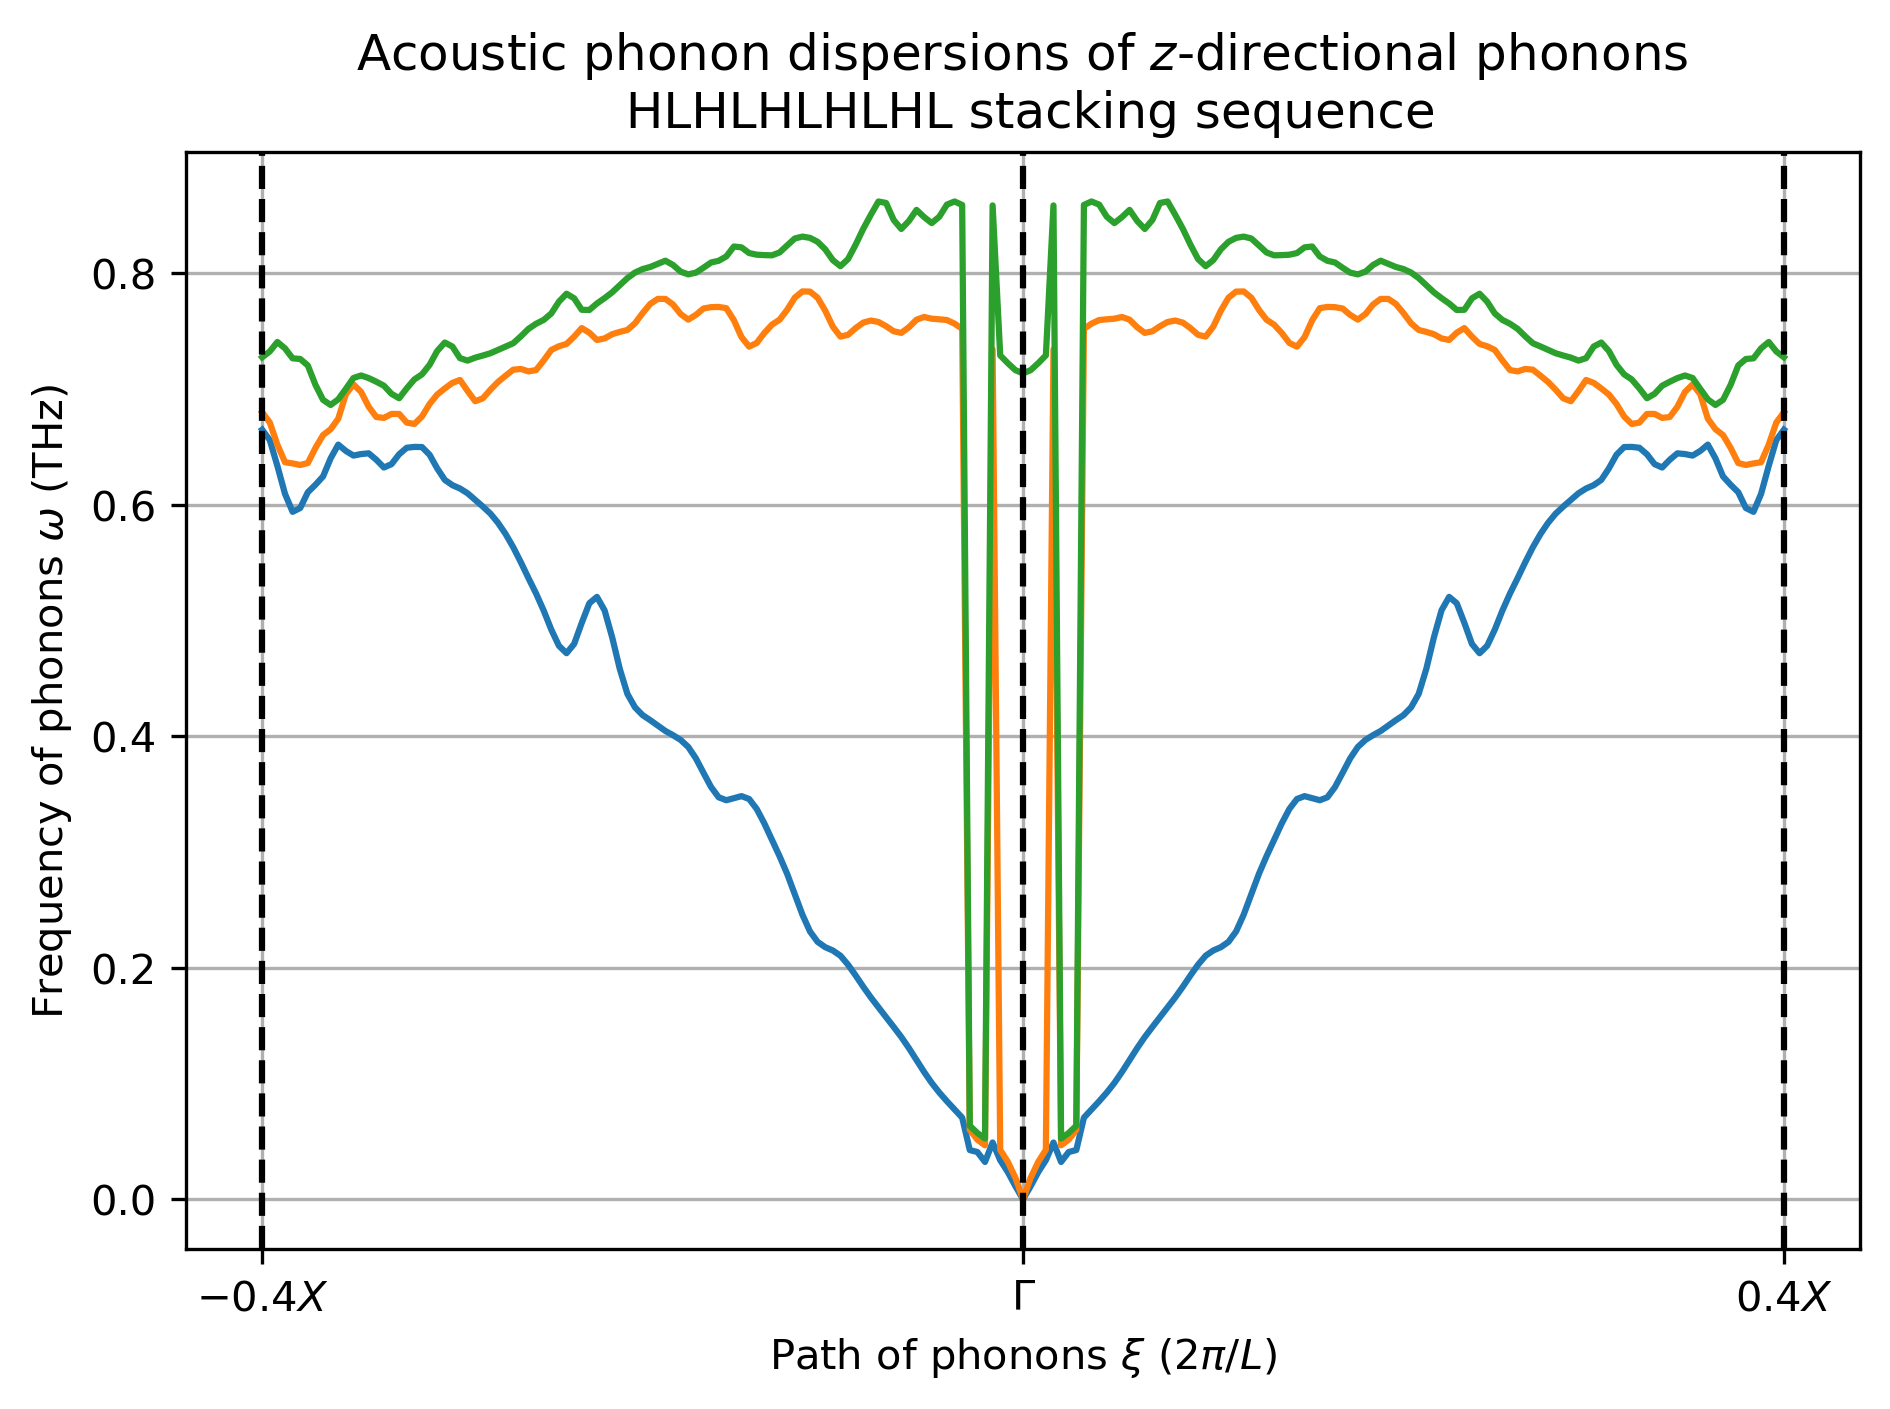

In [26]:
data_z = np.loadtxt("HLHLHLHLHL_z.dat")
# Extract q, which gives us the path
q = data_z[:,3] # y and z should be equivalent here     
# And the frequencies, which are 4th column onwards in our data
freqs_z = data_z[:,4:]

plt.plot(q,freqs_z[:,2:5])
#plt.plot(q, LA_y, label="[010] direction (y)")

# Assign gamma and X labels describing the path of phonons
mid = len(q) // 2
plt.xticks([q[0], q[mid], q[-1]], [r"$-0.4X$", r"$\Gamma$", r"$0.4X$"])

# Make it clearer
plt.axvline(q[0],  linestyle="--",color='black')
plt.axvline(q[mid], linestyle="--", color='black')
plt.axvline(q[-1], linestyle="--", color='black')

plt.xlabel(r"Path of phonons $\xi $ ($2 \pi / L$)")
plt.ylabel(r"Frequency of phonons $\omega$ (THz)")
plt.title("Acoustic phonon dispersions of $z$-directional phonons \n HLHLHLHLHL stacking sequence")
plt.grid()
#plt.ylim(-0.1,1)
plt.tight_layout()

## Longitudinal acoustic dispersion relations

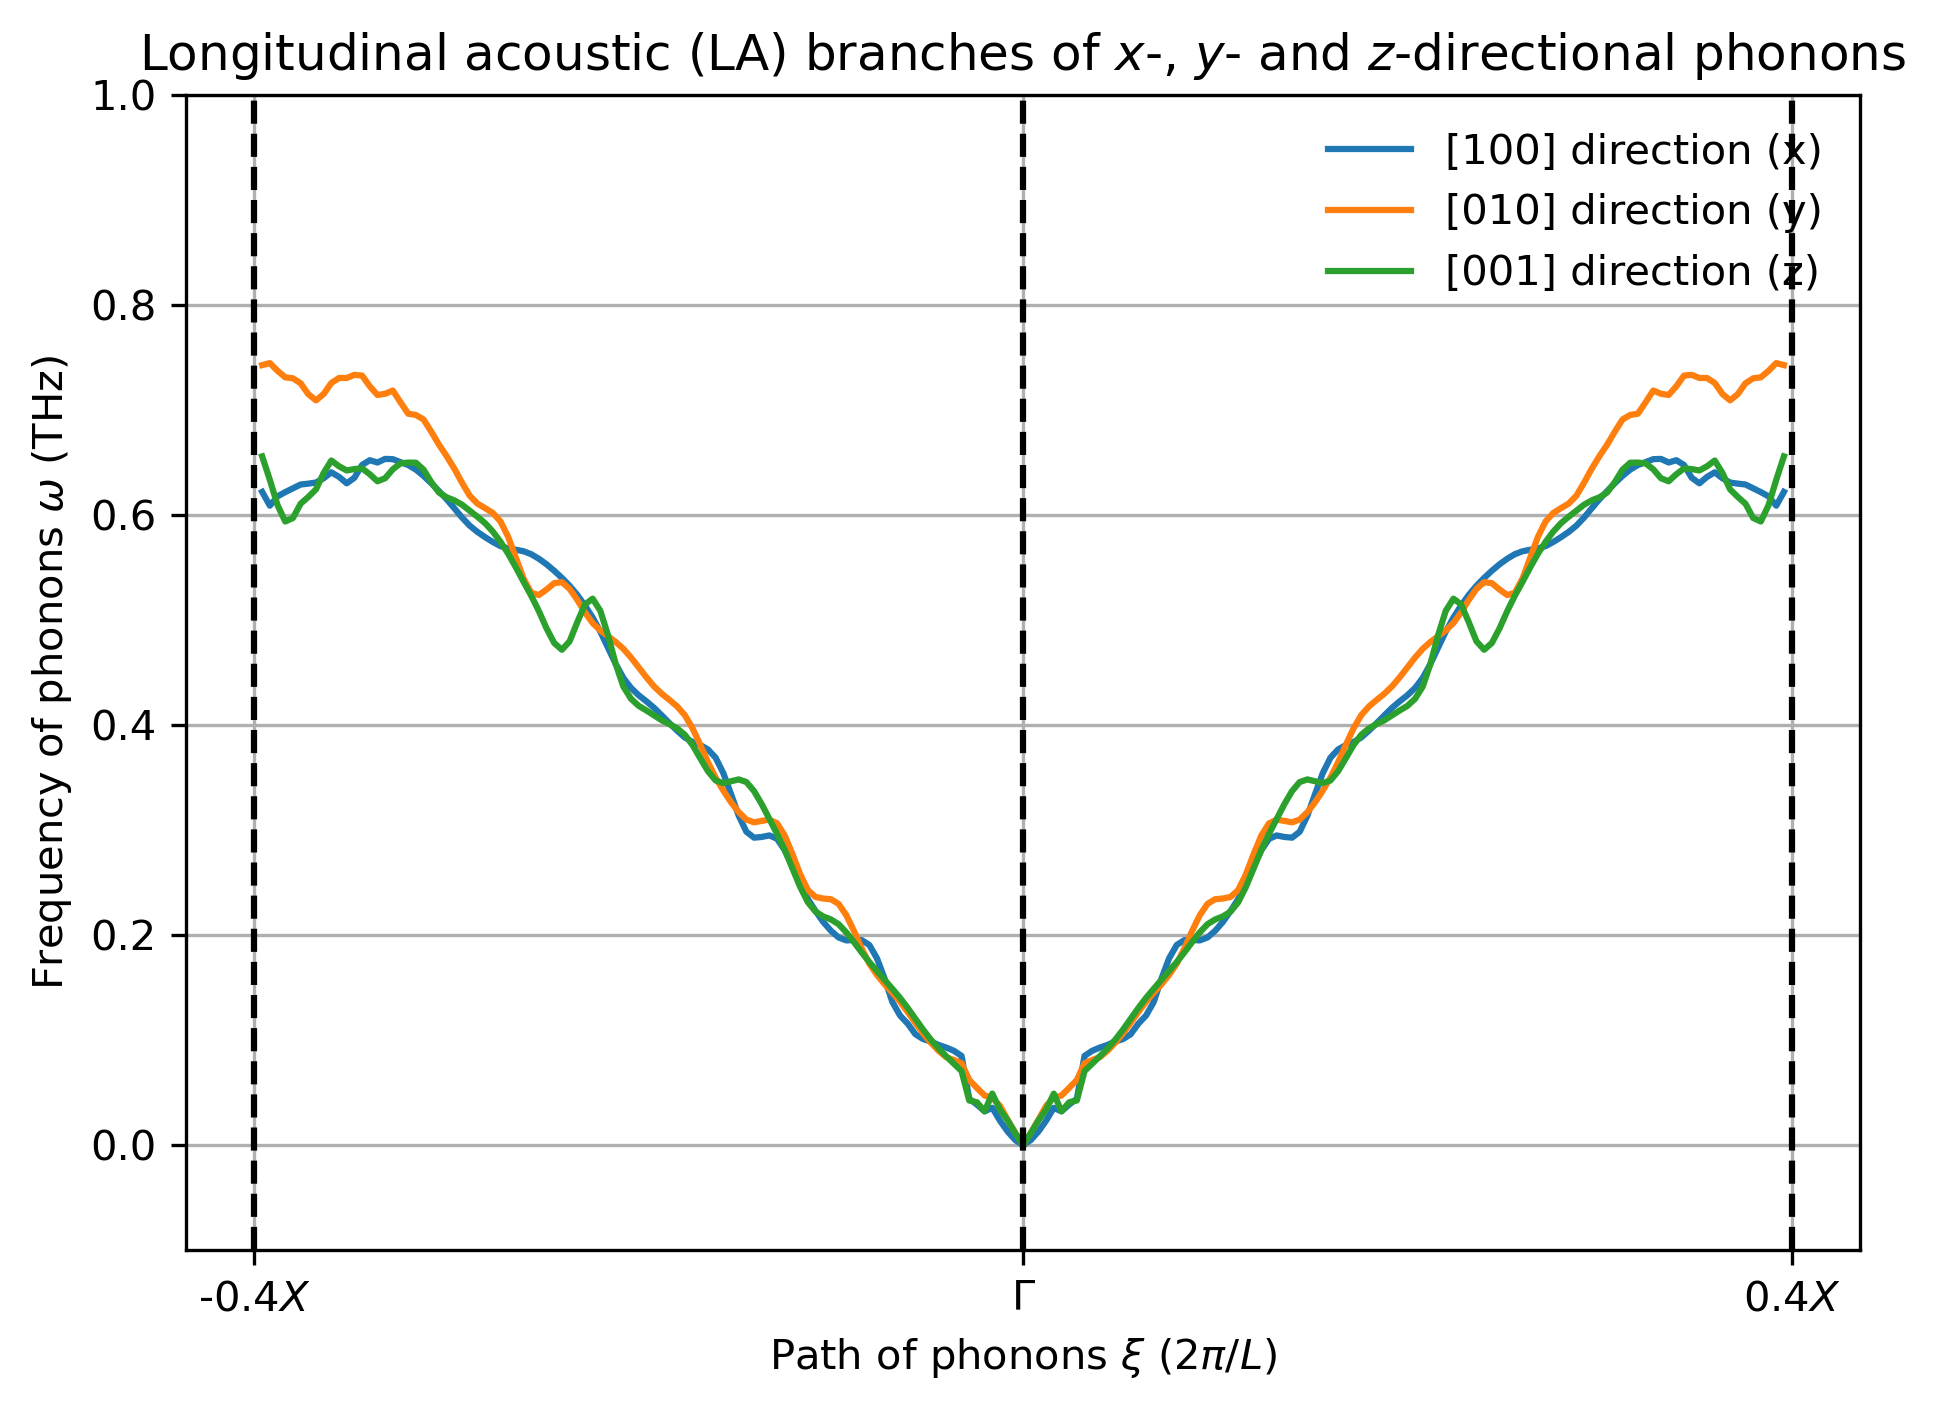

In [28]:
# Load path data for each path direction
data_x = np.loadtxt("HLHLHLHLHL_x.dat")
data_y = np.loadtxt("HLHLHLHLHL_y.dat")
data_z = np.loadtxt("HLHLHLHLHL_z.dat")

# Extract q, which gives us the path
q = data_x[:,3] # y and z should be equivalent here     
# And the frequencies, which are 4th column onwards in our data
freqs_x = data_x[:,4:]; freqs_y = data_y[:,4:]; freqs_z = data_z[:,4:]

# Extract the longitudinal acoustic branch, needed for the speed of sound
LA_x = freqs_x[:,2]
LA_y = freqs_y[:,2]
LA_z = freqs_z[:,2]

# Plot them
plt.plot(q[1:-1], LA_x[1:-1], label="[100] direction (x)")
plt.plot(q[1:-1], LA_y[1:-1], label="[010] direction (y)")
plt.plot(q[1:-1], LA_z[1:-1], label="[001] direction (z)")

# Assign gamma and X labels describing the path of phonons
mid = len(q) // 2
plt.xticks([q[0], q[mid], q[-1]], [r"-0.4$X$", r"$\Gamma$", r"$0.4X$"])

# Make it clearer
plt.axvline(q[0],  linestyle="--",color='black')
plt.axvline(q[mid], linestyle="--", color='black')
plt.axvline(q[-1], linestyle="--", color='black')

plt.xlabel(r"Path of phonons $\xi $ ($2 \pi / L$)")
plt.ylabel(r"Frequency of phonons $\omega$ (THz)")
plt.title("Longitudinal acoustic (LA) branches of $x$-, $y$- and $z$-directional phonons")
plt.legend()
plt.grid()
plt.ylim(-0.1,1)
plt.tight_layout()
